## SPAC Analysis on Lymph Node Tissue Dataset
**Date: 08-2025**

## Introduction

This notebook demonstrates the analysis of a normal lymph node tissue dataset using the SPAC (SPAtial single-Cell analysis) toolkit v0.9.0. The analysis aims to:
- Assess data quality through comprehensive visualization
- Identify cellular phenotypes using unsupervised clustering
- Characterize spatial relationships between cell types
- Discover novel cell populations and their biological significance

### Dataset Overview
- **Source**: Normal human lymph node tissue microarray (TMA) from CyCIF (Cyclic Immunofluorescence) imaging, preprocessed by MCMICRO, downloaded as "example_lymphnode_data.csv"
- **Size**: 4,825 cells
- **Markers**: 33 protein markers
## Module Imports & Utility Functions

In [1]:
# Import functions from the updated SPAC package
from spac.data_utils import load_csv_files, select_values, combine_dfs, ingest_cells 
from spac.transformations import arcsinh_transformation, z_score_normalization, run_umap, phenograph_clustering
from spac.visualization import boxplot, histogram, hierarchical_heatmap, dimensionality_reduction_plot, spatial_plot, sankey_plot, visualize_nearest_neighbor, plot_ripley_l
from spac.spatial_analysis import spatial_interaction, calculate_nearest_neighbor, ripley_l
from spac.phenotyping import assign_manual_phenotypes
from spac.transformations import rename_annotations
from functools import partial

import numpy as np
import pandas as pd
from math import ceil, sqrt
import matplotlib.pyplot as plt
import seaborn as sns 
import copy
import anndata
import scanpy as sc
import plotly.io as pio
from PIL import Image as PILImage
from pprint import pprint
from io import BytesIO
%matplotlib inline

# Reduce verbosity settings
import warnings
warnings.filterwarnings('ignore')

# Configure root logger to suppress INFO
# Set logging to only show warnings and errors
import logging
import sys
logging.getLogger().setLevel(logging.WARNING)

# Configure specific loggers
logging.getLogger('spac').setLevel(logging.WARNING)
logging.getLogger('spac.utils').setLevel(logging.WARNING)  # In case of sub-loggers
logging.getLogger('spac.visualization').setLevel(logging.WARNING)

# Also disable propagation to root logger
logging.getLogger('spac').propagate = False

# For scanpy verbosity
sc.settings.verbosity = 1  # Only show errors
# Set visualization parameters
sc.settings.set_figure_params(dpi=80, facecolor='white')

# Suppress matplotlib debug messages
logging.getLogger('matplotlib').setLevel(logging.WARNING)


/Users/liuf9/opt/anaconda3/envs/spac-3913/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Define Input/Output Paths

In [2]:
# Setup working directory and file paths
data_csv = "example_lymphnode_data.csv"

## Utility Functions

In [3]:
def generate_grid_frame(adata, fig_width=12, fig_height=12, dpi=300, n_plots=None):
    """Generate a grid frame for multiple subplots."""
    if n_plots is None:
        n_annotations = len(adata.obs.columns.tolist())
    else:
        n_annotations = n_plots
    
    n_cols = ceil(sqrt(n_annotations))
    n_rows = ceil(n_annotations / n_cols)
    
    fig, axes = plt.subplots(
        nrows=n_rows,
        ncols=n_cols,
        figsize=(fig_width, fig_height),
        dpi=dpi
    )
    axes = axes.flatten()
    return fig, axes

## Step 1: Data Loading & Preprocessing

### 1.1 Load CSV Data

In [4]:
# Load data without verbose output
import io
import contextlib

file_names = [data_csv]

# Suppress all output from load_csv_files
with io.StringIO() as buf, contextlib.redirect_stdout(buf):
    data = load_csv_files(file_names)

# Get the dataframe
df = data[0] if isinstance(data, list) else data

# Print only your custom summary
print(f"✓ Dataset loaded: {df.shape[0]} cells × {df.shape[1]} features")
print(f"✓ Marker columns: {sum(col not in ['CellID', 'X_centroid', 'Y_centroid'] for col in df.columns)} markers")

✓ Dataset loaded: 4825 cells × 85 features
✓ Marker columns: 82 markers


### 1.2 Define Phenotype Definitions

We'll use manual phenotype definitions based on cell lineage markers to initially characterize cell types. Specifically, define the name and the expression of their phenotypes  based on the binary (e.g., '0' or '1') of categorical (e.g., "CD4+" or "CD4-") values of gated marker(s). A new column with the annotation "Manual Annotation Name" will be added.




In [5]:
# Define the manual phenotype codes and names
phenotype_definitions = pd.DataFrame([
    {"phenotype_code": "CD3D+CD4+FOXP3+", "phenotype_name": "Regulatory T Cell"},
    {"phenotype_code": "CD3D+CD4+", "phenotype_name": "Helper T Cell"},
    {"phenotype_code": "CD3D+CD8A+", "phenotype_name": "Cytotoxic T Cell"},
    {"phenotype_code": "CD3D+", "phenotype_name": "T Cell"},
    {"phenotype_code": "CD20+", "phenotype_name": "B Cell"},
    {"phenotype_code": "CD21+CD20-", "phenotype_name": "Follicular Dendritic Cell"},
    {"phenotype_code": "CD56+", "phenotype_name": "NK Cell"},
    {"phenotype_code": "CD68+", "phenotype_name": "CD68+ Macrophage"},
    {"phenotype_code": "CD11C+", "phenotype_name": "Dendritic Cell"},
    {"phenotype_code": "CD15+", "phenotype_name": "Granulocyte"},
    {"phenotype_code": "KI67+", "phenotype_name": "Proliferating Cell"},
    {"phenotype_code": "PD1+", "phenotype_name": "Activated T/B Cell"},
    {"phenotype_code": "HLADR+", "phenotype_name": "Activated APC"},
    {"phenotype_code": "CD163+", "phenotype_name": "CD163+ Macrophage"}
])

# Apply manual phenotyping with suppressed output
with io.StringIO() as buf, contextlib.redirect_stdout(buf):
    assign_manual_phenotypes(df, phenotype_definitions, suffix="_expression")
    
# Print custom output
print("✓ Manual phenotypes assigned successfully!")
print(f"  - Added {len(phenotype_definitions)} phenotype definitions")
print(f"  - Processed {len(df)} cells")

✓ Manual phenotypes assigned successfully!
  - Added 14 phenotype definitions
  - Processed 4825 cells


### 1.3 Create AnnData Object

Convert the DataFrame to an AnnData object for downstream analysis.

In [6]:
# Define features to include in analysis
feature_names = [
    "CD25", "CD2", "CD10", "CD163", "CD3D", "CD5", "CD30", "ACTIN", "CD45",
    "CD206", "CD68", "PD1", "KI67", "CD11C", "CD7", "CD8A", "FOXP3", "CD20",
    "CD4", "HLADR", "PSTAT3", "PS6", "PERK", "CD21", "CD43", "NOS2", "PDL1",
    "CD11B", "CD57", "MHCI", "CD15", "ASMA", "CD56"
]

# Create regex patterns for feature selection
regex_str = [f"^{feature}$" for feature in feature_names]

# Define spatial coordinates and annotations
x_col = "X_centroid"
y_col = "Y_centroid"
annotation = ["broad_cell_type", "detailed_cell_type", "manual_phenotype"]

# Create AnnData object
adata = ingest_cells(
    dataframe=df,
    regex_str=regex_str,
    x_col=x_col,
    y_col=y_col,
    annotation=annotation
)

print(f"AnnData object created: {adata}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of features: {adata.n_vars}")

^CD25$
^CD2$
^CD10$
^CD163$
^CD3D$
^CD5$
^CD30$
^ACTIN$
^CD45$
^CD206$
^CD68$
^PD1$
^KI67$
^CD11C$
^CD7$
^CD8A$
^FOXP3$
^CD20$
^CD4$
^HLADR$
^PSTAT3$
^PS6$
^PERK$
^CD21$
^CD43$
^NOS2$
^PDL1$
^CD11B$
^CD57$
^MHCI$
^CD15$
^ASMA$
^CD56$
AnnData object created: AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype'
    obsm: 'spatial'
Number of cells: 4825
Number of features: 33


## Step 2: Quality Control and Data Visualization

### 2.1 Marker Expression Distribution

First, let's examine the distribution of all markers to identify potential quality issues.

Calculating Box Plot...
Key QC observations:
- MHCI: High expression in nucleated cells (expected)
- CD45: High expression in immune cells (expected)
- CD20/CD21: High expression in B cells (expected)
- CD56: Unexpectedly high expression - may indicate background noise
  (NK cells are typically rare in normal lymph nodes)


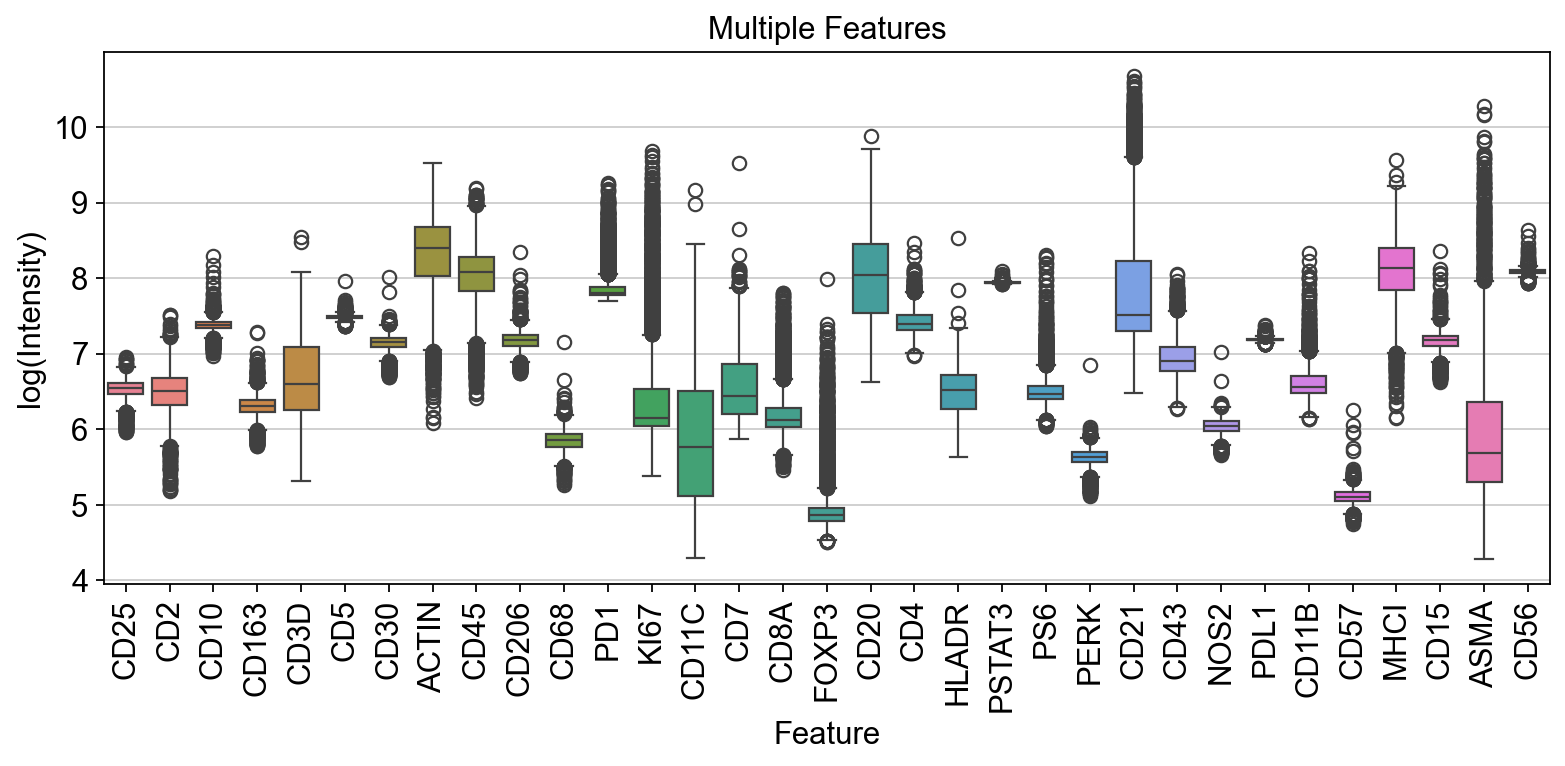

In [7]:
# Create boxplot for all features
summary_stats_table = boxplot(
    adata=adata,
    annotation=None,
    second_annotation=None,
    features=adata.var_names.tolist(),
    layer=None,
    log_scale=True,
    showfliers=True
)

print("Key QC observations:")
print("- MHCI: High expression in nucleated cells (expected)")
print("- CD45: High expression in immune cells (expected)")
print("- CD20/CD21: High expression in B cells (expected)")
print("- CD56: Unexpectedly high expression - may indicate background noise")
print("  (NK cells are typically rare in normal lymph nodes)")

### 2.2 Feature-Specific Histograms

Let's examine CD21 expression across different cell types.

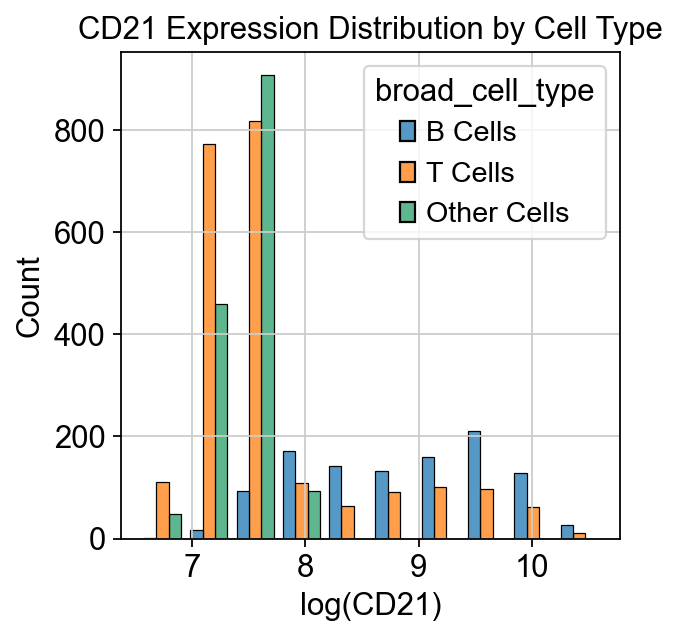

In [8]:
# Create histogram for CD21 expression by cell type
fig = histogram(
    adata, 
    feature="CD21",
    group_by="broad_cell_type",
    layer=None,
    together=True,
    x_log_scale=True,
    y_log_scale=False,
    multiple="dodge",
    shrink=0.8,
    bins="auto",
    alpha=0.75,
    stat="count"
)

plt.title("CD21 Expression Distribution by Cell Type")
plt.show()

## Step 3: Data Transformation

### 3.1 Arcsinh Transformation

Apply arcsinh transformation to normalize marker intensities. SPAC utilizes the arcsinh function, a non-linear transformation method, and scales biomarker expression levels using a Co-Factor value or a determined percentile set per feature for consistent feature comparison. This technique is useful for datasets with a broad range of feature expression levels, ensuring that each feature's distribution is accurately represented after transformation.



In [9]:
# Normalize features with arcsinh transformation
norm_output_layer = 'arcsinh_percentile'
arcsinh_transformation(
    adata,
    percentile=10,
    output_layer=norm_output_layer
)
print(f"Arcsinh transformation complete. Data stored in layer: '{norm_output_layer}'")

Arcsinh transformation complete. Data stored in layer: 'arcsinh_percentile'


### 3.2 Z-score Normalization

Further normalize the data using z-score transformation, which computes z-scores for each feature, effectively normalizing the values of that feature by centering it around the mean of zero and scaling to have a standard deviation of one.

In [10]:
# Apply z-score normalization
norm_zscore_output_layer = 'arcsinh_z_scores'
z_score_normalization(
    adata,
    input_layer=norm_output_layer,
    output_layer=norm_zscore_output_layer
)


Z-score normalization completed. Data stored in layer "arcsinh_z_scores".


## Step 4: Unsupervised Clustering

### 4.1 PhenoGraph Clustering

Apply PhenoGraph clustering to identify cellular populations without prior knowledge. Specifically, the Phenograph Clustering function identifies cell types or states in single-cell data by grouping cells into clusters based on their phenotypic similarities. It utilizes the Leiden algorithm for community detection, providing a structured approach to understand cellular diversity and similarity. The output of this clustering, including cell classifications, is added to the analysis under a specifically designated annotation name that is customized by the user,  facilitating subsequent analysis. 

In addition, SPAC also provides UTAG Clustering (Unsupervised discovery of Tissue Architecture with Graphs) that discover spatial tissue domains (tissue micro‑environments) by combining phenotypes (feature intensities) and spatial proximity of cells.





In [11]:
# Run PhenoGraph clustering
resolution = 1
K_NN_Value = 60
annotation_name = f'phenograph_k{K_NN_Value}_r{resolution}'

phenograph_clustering(
    adata,
    layer=norm_zscore_output_layer,
    features=adata.var.index.to_list(),
    k=K_NN_Value,
    seed=42,
    output_annotation=annotation_name,
    resolution_parameter=resolution
)

num_clusters = adata.obs[annotation_name].nunique()
print(f"PhenoGraph identified {num_clusters} clusters")

# Display cluster sizes
cluster_counts = adata.obs[annotation_name].value_counts().sort_index()
print("\nCells per cluster:")
print(cluster_counts)

Finding 60 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 0.2288522720336914 seconds
Jaccard graph constructed in 6.283718824386597 seconds
Running Leiden optimization
Leiden completed in 0.4517710208892822 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 11.001877069473267 seconds
PhenoGraph identified 10 clusters

Cells per cluster:
phenograph_k60_r1
0    971
1    801
2    652
3    650
4    417
5    332
6    326
7    284
8    266
9    126
Name: count, dtype: int64



Generating heatmap to analyze cluster marker expression...


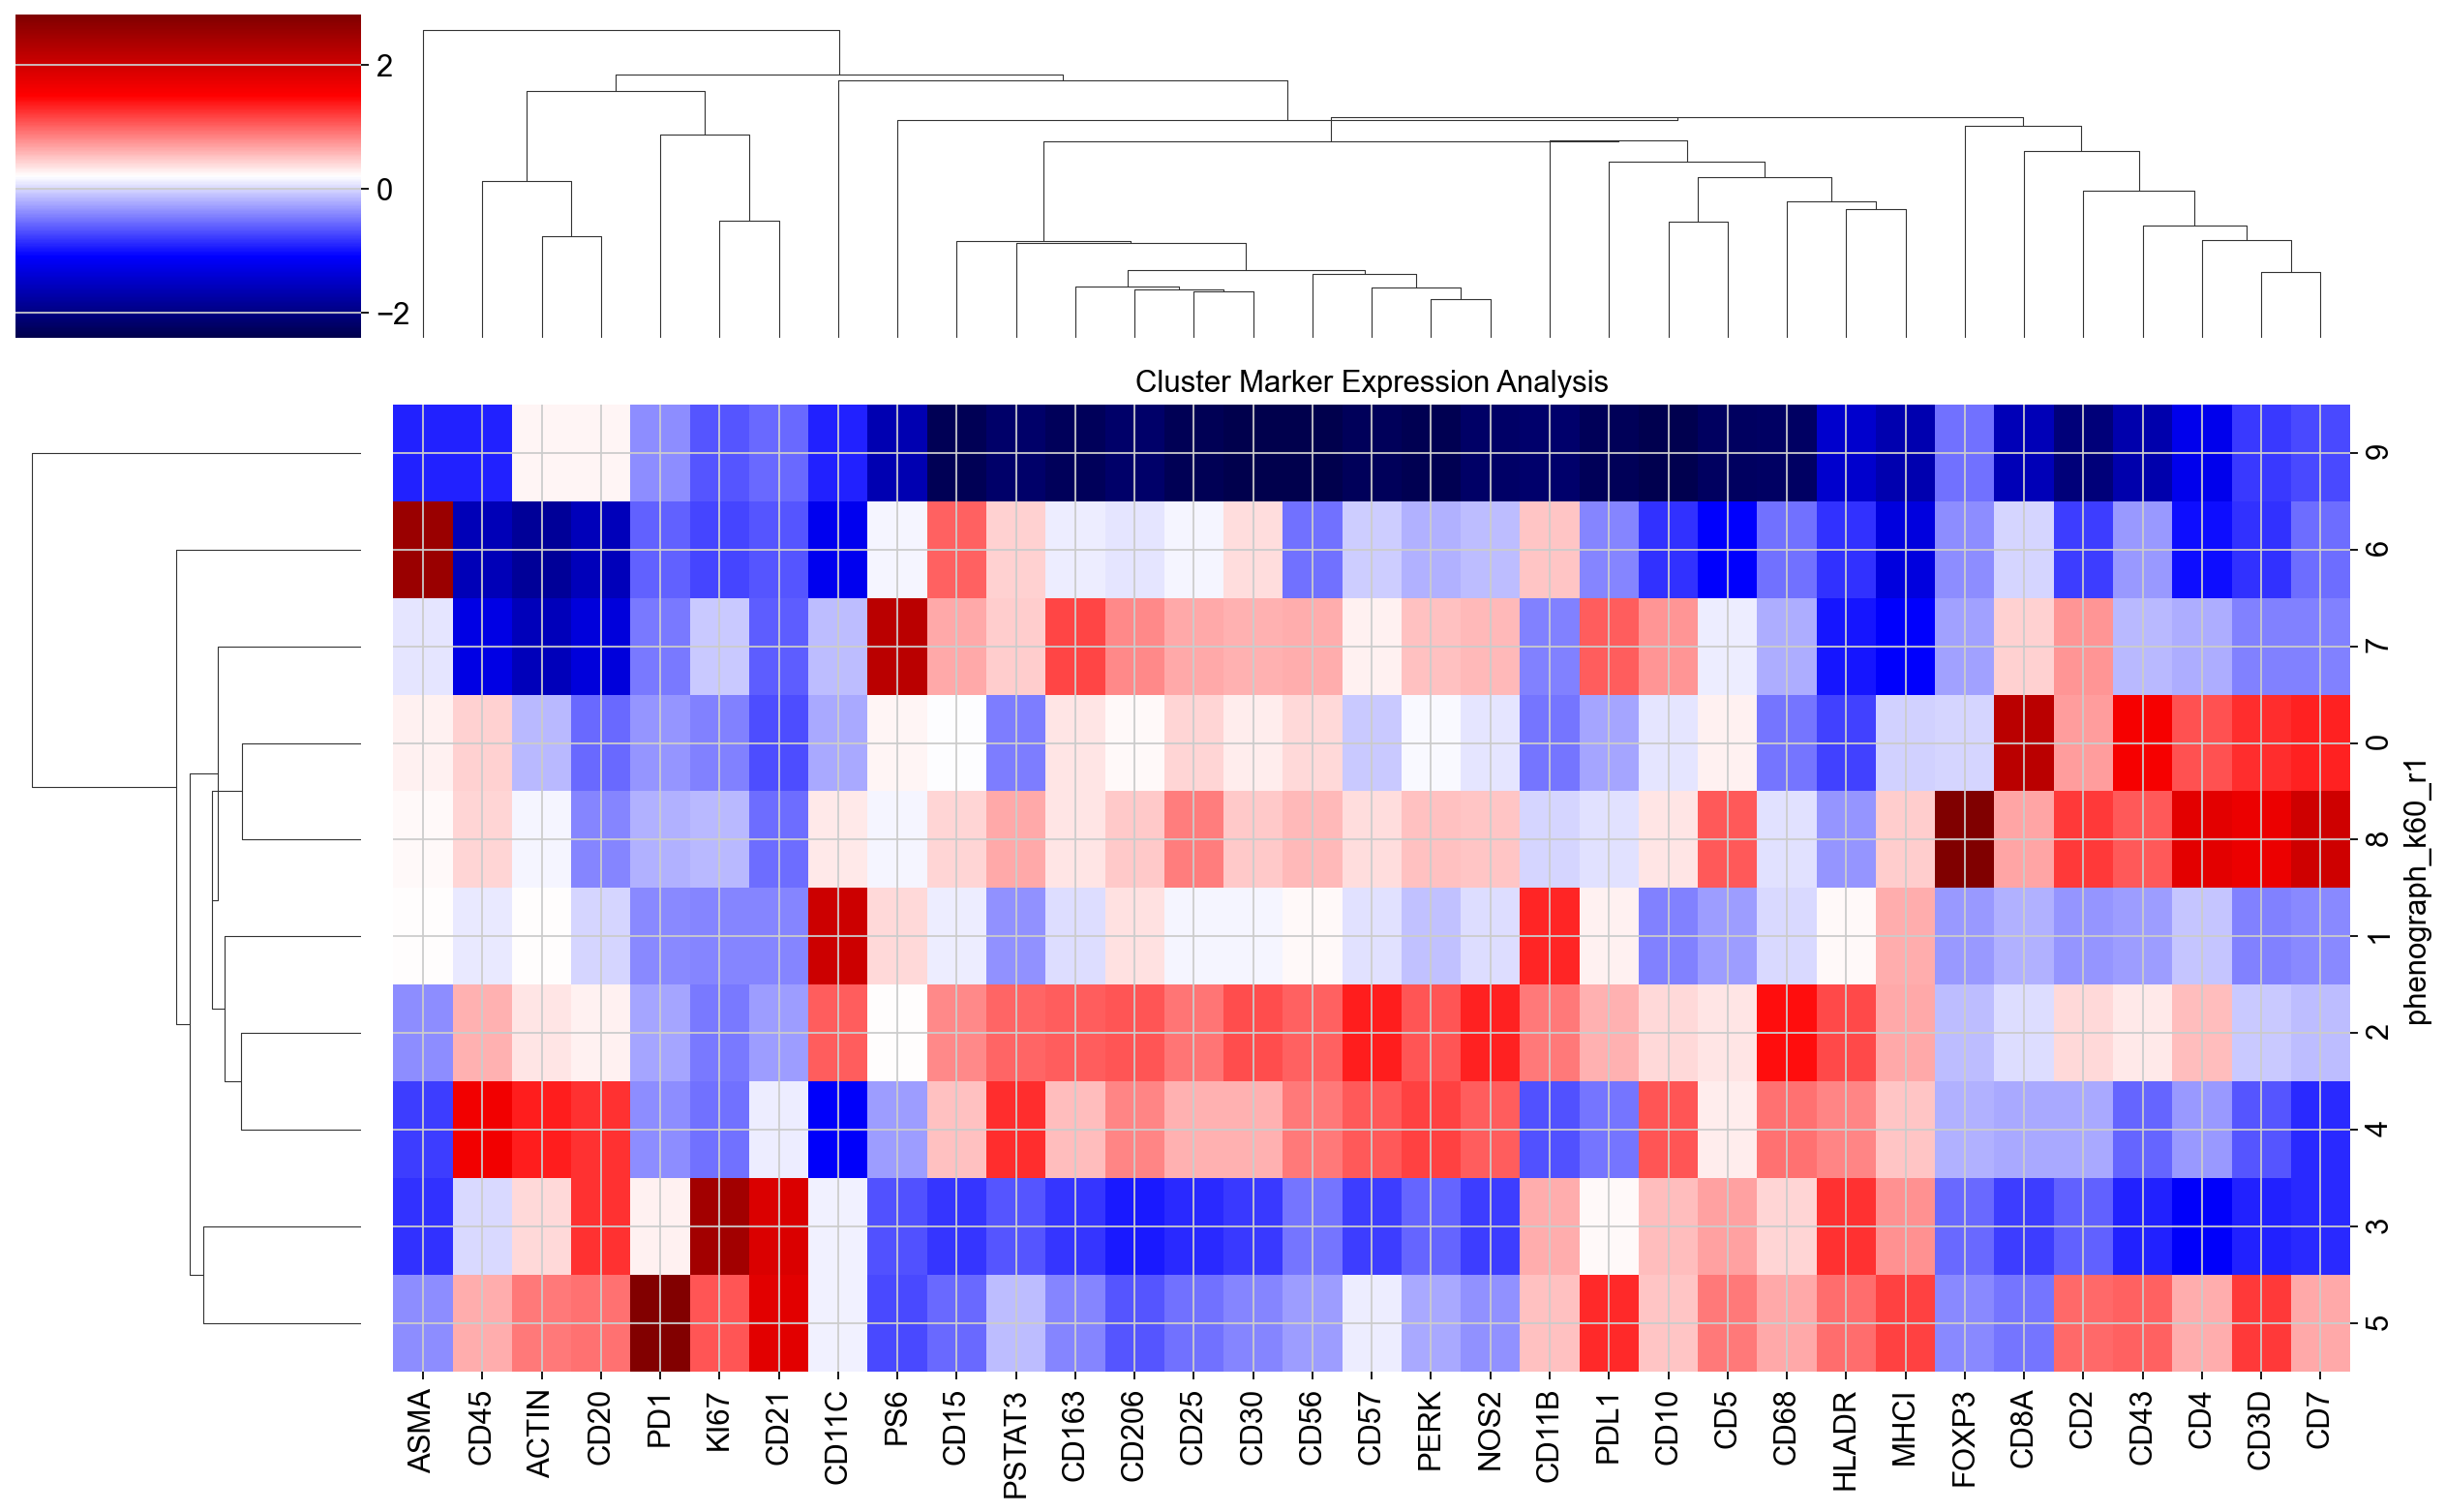

In [12]:
# Create hierarchical heatmap to examine cluster marker expression
print("\nGenerating heatmap to analyze cluster marker expression...")

# Suppress verbose output from heatmap function
with io.StringIO() as buf, contextlib.redirect_stdout(buf):
    _, clustergrid, _ = hierarchical_heatmap(
        adata,
        annotation=annotation_name,
        features=None,  # Use all features
        layer=norm_zscore_output_layer,
        cluster_feature=True,
        cluster_annotations=True,
        standard_scale=None,
        z_score='feature',  # Show relative expression
        swap_axes=False,
        rotate_label=False,
        figsize=(16, 10),
        dendrogram_ratio=(0.15, 0.25),
        cmap='seismic'
    )

clustergrid.ax_heatmap.set_title('Cluster Marker Expression Analysis', fontsize=14)
plt.tight_layout()
plt.show()

In [13]:
# Print instructions for manual interpretation
print("\nIMPORTANT: Review the heatmap above before proceeding!")
print("Based on marker expression patterns, manually determine the cell type for each cluster.")
print("Update the mappings below based on your observations:")
print("\nKey markers to consider:")
print("- T cells: CD3D+, CD4+ or CD8A+")
print("- B cells: CD20+, CD45+")
print("- Myeloid: CD11C+, CD11B+, CD68+")
print("- NK cells: CD56+")
print("- Tfh cells: PD1+, CD4+, CD3D+")


IMPORTANT: Review the heatmap above before proceeding!
Based on marker expression patterns, manually determine the cell type for each cluster.
Update the mappings below based on your observations:

Key markers to consider:
- T cells: CD3D+, CD4+ or CD8A+
- B cells: CD20+, CD45+
- Myeloid: CD11C+, CD11B+, CD68+
- NK cells: CD56+
- Tfh cells: PD1+, CD4+, CD3D+


### 4.2 Cluster Annotation

Based on marker expression patterns, assign biological cell types to clusters. The Rename_annotation function allows users to modify label names in a dataset by mapping existing labels to new ones. It requires a two-column manual entry for this purpose: the first column (Source Annotation) contains the original labels, and the second column (New Annotation) lists the desired new labels. For successful renaming, there must be an exact match between the original labels in the Source Label Column and those present in the dataset.



In [14]:
# Define cluster-to-cell type mapping based on marker expression
original_column = f"phenograph_k{K_NN_Value}_r{resolution}"
renamed_column = "renamed_clusters"

# First, check what values actually exist in the clustering column
print(f"Unique cluster values in {original_column}:")
print(adata.obs[original_column].unique())
print(f"Data type: {adata.obs[original_column].dtype}")

# Convert cluster values to check their type
actual_clusters = adata.obs[original_column].astype(str).value_counts().sort_index()
print("\nActual cluster distribution:")
for cluster, count in actual_clusters.items():
    print(f"  Cluster {cluster}: {count} cells")

# Now create mappings based on actual cluster values
# If clusters are integers, use integer keys:
mappings = {
    "0": "CD8 T cells",          # CD8A-high, CD43-high, CD3D-high
    "1": "Myeloid cells",        # CD11c-high, CD11b-high, CD206-high, CD68-high, CD56-medium, HLA-DR-high
    "2": "Myeloid cells",        # CD11c-high, CD11b-high, MHCI
    "3": "Proliferative B cells",  # CD21-high, Ki67-high, CD20-high, PD1-dim, HLA-DR-high
    "4": "B cells",              # CD45-high, CD20-high, HLA-DR-high
    "5": "Follicular helper T cells (Tfh)",  # PD1-high, CD21-high, CD3D-medium, CD4-medium, CD8-neg, CD57-medium, CD11C-medium, PDL1-medium, CD2-medium, CD43-medium, CD20-medium
    "6": "ASMA+ cells",          # ASMA+ high
    "7": "NK cells",             # CD56-high, PS6-high, CD2-high, CD163-high, PDL1-highCD56-high, PS6-high, CD2-high, CD163-high, PDL1-high
    "8": "Regulatory T cells",   # Foxp3-high, CD4-high, CD3D-high, CD7-high, CD5-medium
    "9": "Others"                  
}

# Or convert to strings if needed
mappings_str = {str(k): v for k, v in mappings.items()}

rename_annotations(
    adata,
    src_annotation=original_column,
    dest_annotation=renamed_column,
    mappings=mappings_str
)

print("\nCell types assigned to clusters:")
for cluster in sorted(adata.obs[original_column].unique()):
    cell_type = mappings_str.get(str(cluster), "Unknown")
    count = (adata.obs[original_column] == cluster).sum()
    print(f"  Cluster {cluster} ({count} cells) → {cell_type}")

Unique cluster values in phenograph_k60_r1:
[3, 5, 0, 2, 1, 4, 8, 6, 9, 7]
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]
Data type: category

Actual cluster distribution:
  Cluster 0: 971 cells
  Cluster 1: 801 cells
  Cluster 2: 652 cells
  Cluster 3: 650 cells
  Cluster 4: 417 cells
  Cluster 5: 332 cells
  Cluster 6: 326 cells
  Cluster 7: 284 cells
  Cluster 8: 266 cells
  Cluster 9: 126 cells
The data type of the original column 'phenograph_k60_r1' is category.

Cell types assigned to clusters:
  Cluster 0 (971 cells) → CD8 T cells
  Cluster 1 (801 cells) → Myeloid cells
  Cluster 2 (652 cells) → Myeloid cells
  Cluster 3 (650 cells) → Proliferative B cells
  Cluster 4 (417 cells) → B cells
  Cluster 5 (332 cells) → Follicular helper T cells (Tfh)
  Cluster 6 (326 cells) → ASMA+ cells
  Cluster 7 (284 cells) → NK cells
  Cluster 8 (266 cells) → Regulatory T cells
  Cluster 9 (126 cells) → Others


### 4.3 Key Finding: Cluster 5 - Follicular Helper T Cells

**Important Discovery**: Cluster 5 shows a unique expression profile:
- **High expression**: PD1, CD21, CD20
- **Medium expression**: CD57, CD11C, CD11B, PDL1, CD3D, CD4, CD2, CD43
- **Negative**: CD8

This profile is characteristic of **Follicular Helper T (Tfh) cells**, which are crucial for germinal center development and B cell maturation. The co-expression pattern suggests this cluster represents a germinal center-like microenvironment.

## Step 5: Dimensionality Reduction

### 5.1 UMAP Analysis

Generate UMAP (Uniform Manifold Approximation and Projection) embeddings to visualize cellular relationships.  

SPAC's UMAP Transformation function reveals underlying patterns, groupings, and relationships in high dimensions datasets by projecting them into a lower-dimensional space (e.g., two dimensions), making it easier to visualize and interpret the data.

It applies a flexible non-linear dimension reduction algorithm (UMAP),  provided by the umap-learn library, which learns the manifold structure of data and find a low dimensional embedding that preserves the essential topological structure of that manifold.



In [15]:
# Run UMAP
n_neighbors = 200
n_components = 2
min_dist = 0.1
metric = 'euclidean'
random_state = 0

run_umap(
    adata=adata,
    n_neighbors=n_neighbors,
    min_dist=min_dist,
    n_components=n_components,
    metric=metric,
    random_state=random_state,
    transform_seed=42,
    layer=norm_zscore_output_layer
)
print("UMAP embedding complete!")

UMAP embedding complete!


### 5.2 Visualize Clusters on UMAP

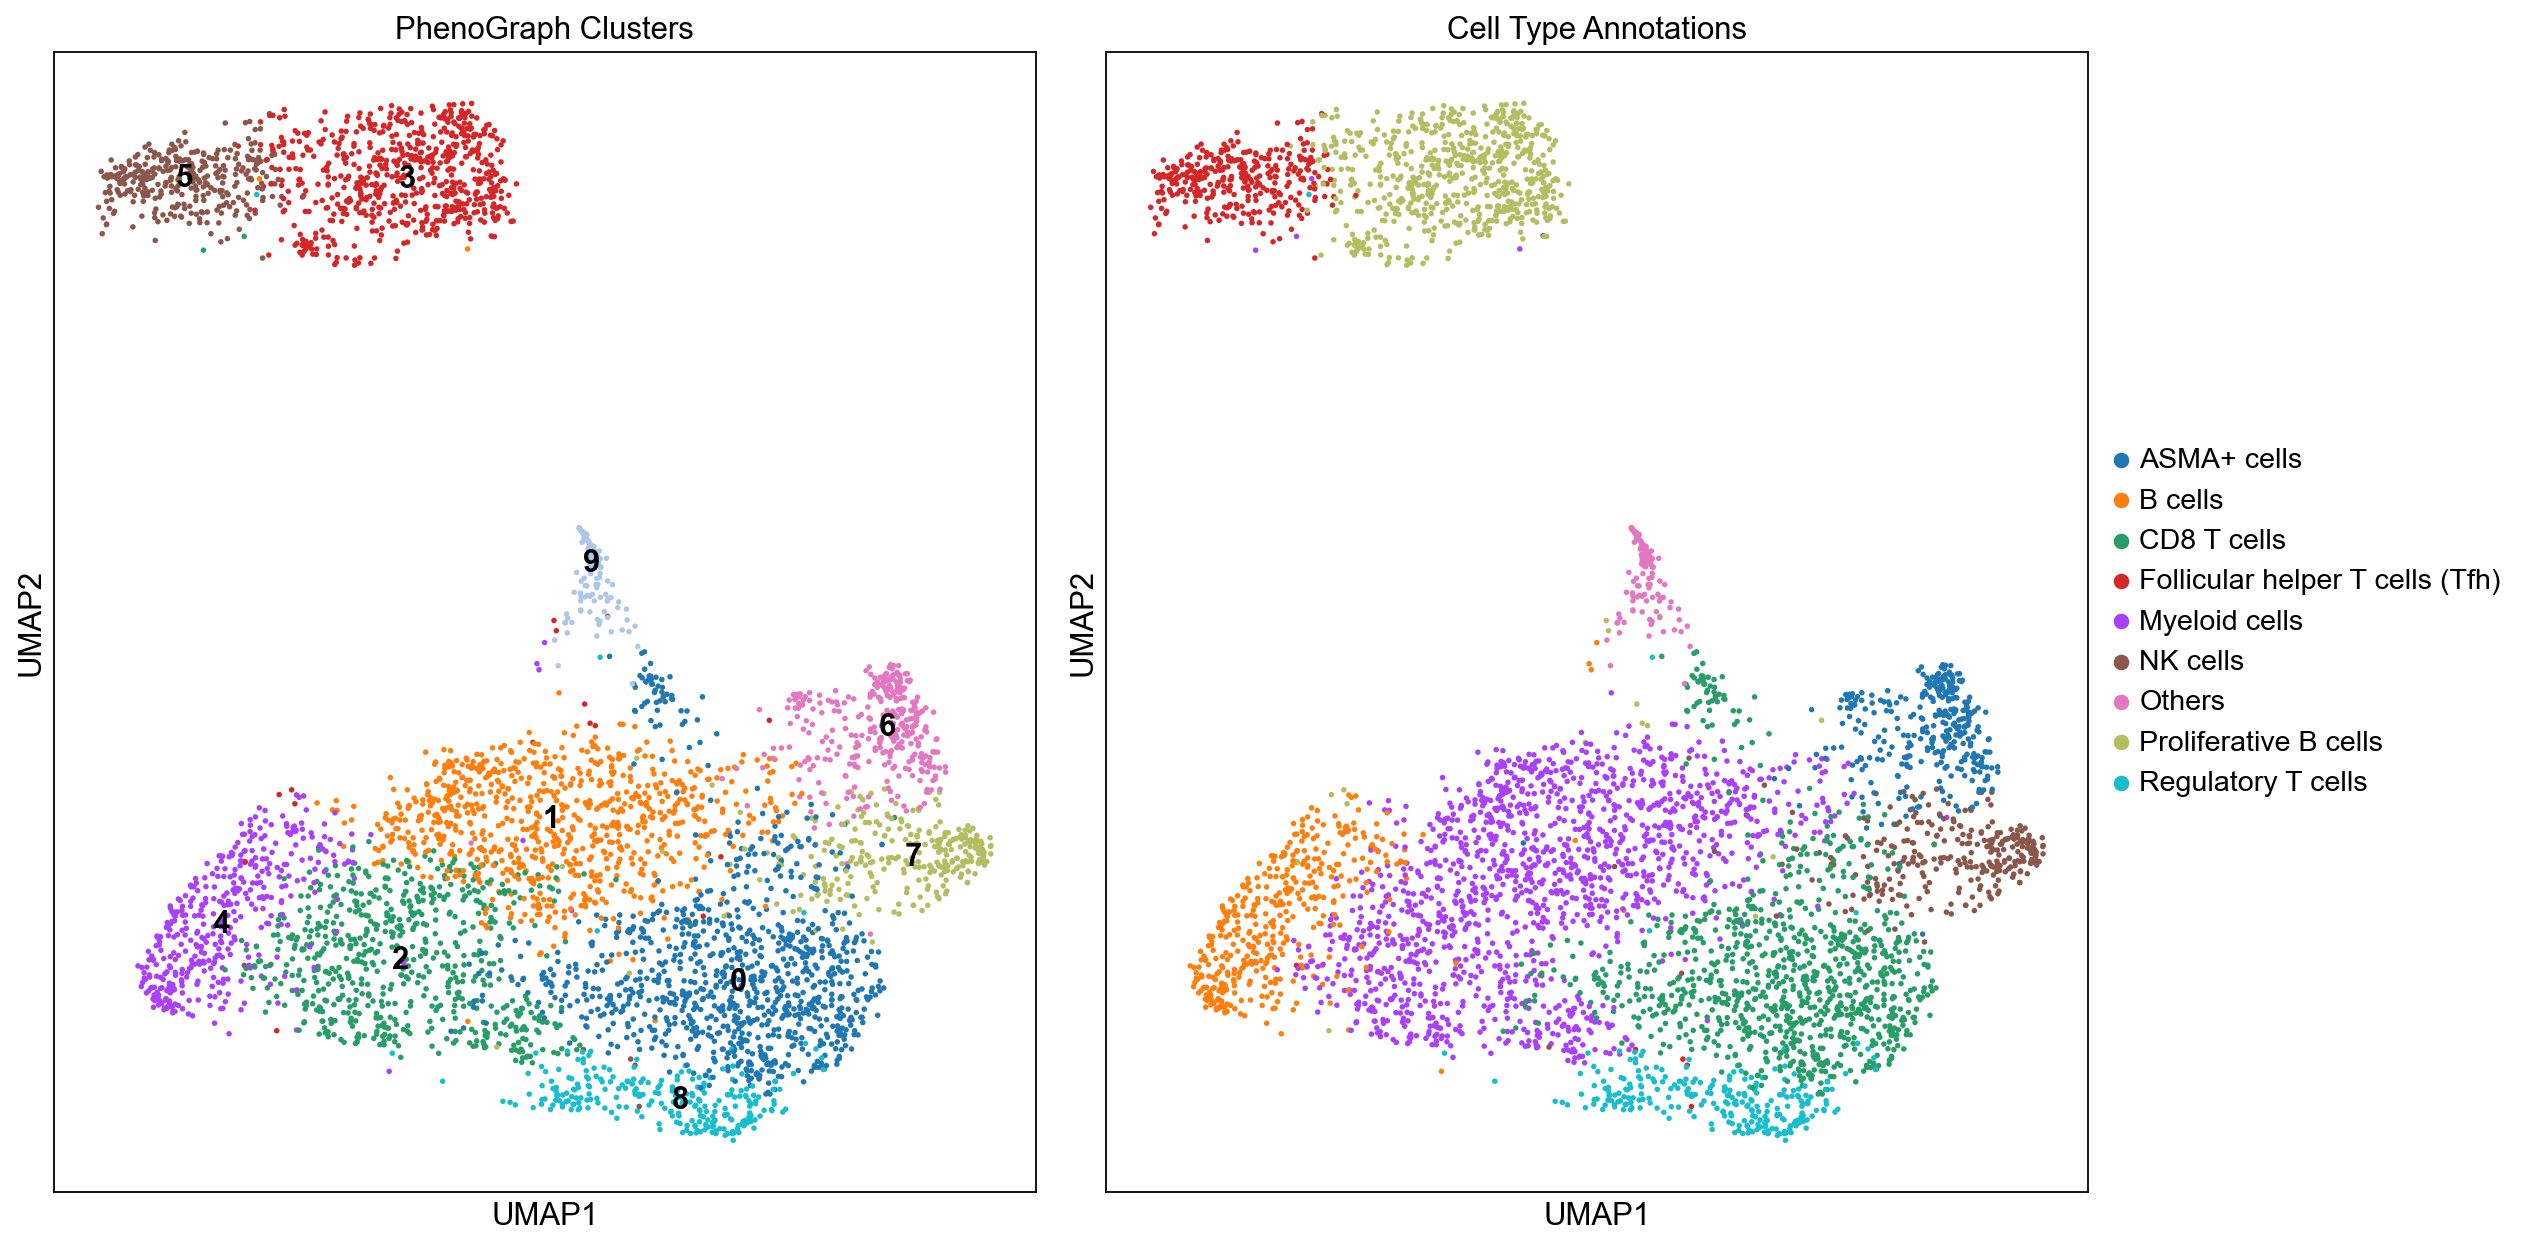

In [16]:
# Create UMAP plots for clusters
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Plot original clusters
sc.pl.umap(adata, color=original_column, ax=axes[0], show=False, 
           title='PhenoGraph Clusters', legend_loc='on data')

# Plot renamed cell types
sc.pl.umap(adata, color=renamed_column, ax=axes[1], show=False,
           title='Cell Type Annotations', legend_loc='right margin')

plt.tight_layout()
plt.show()

### 5.3 Marker Expression on UMAP

Examine the CD3D/CD20 co-expression boundary that may indicate technical artifacts or biological interactions.

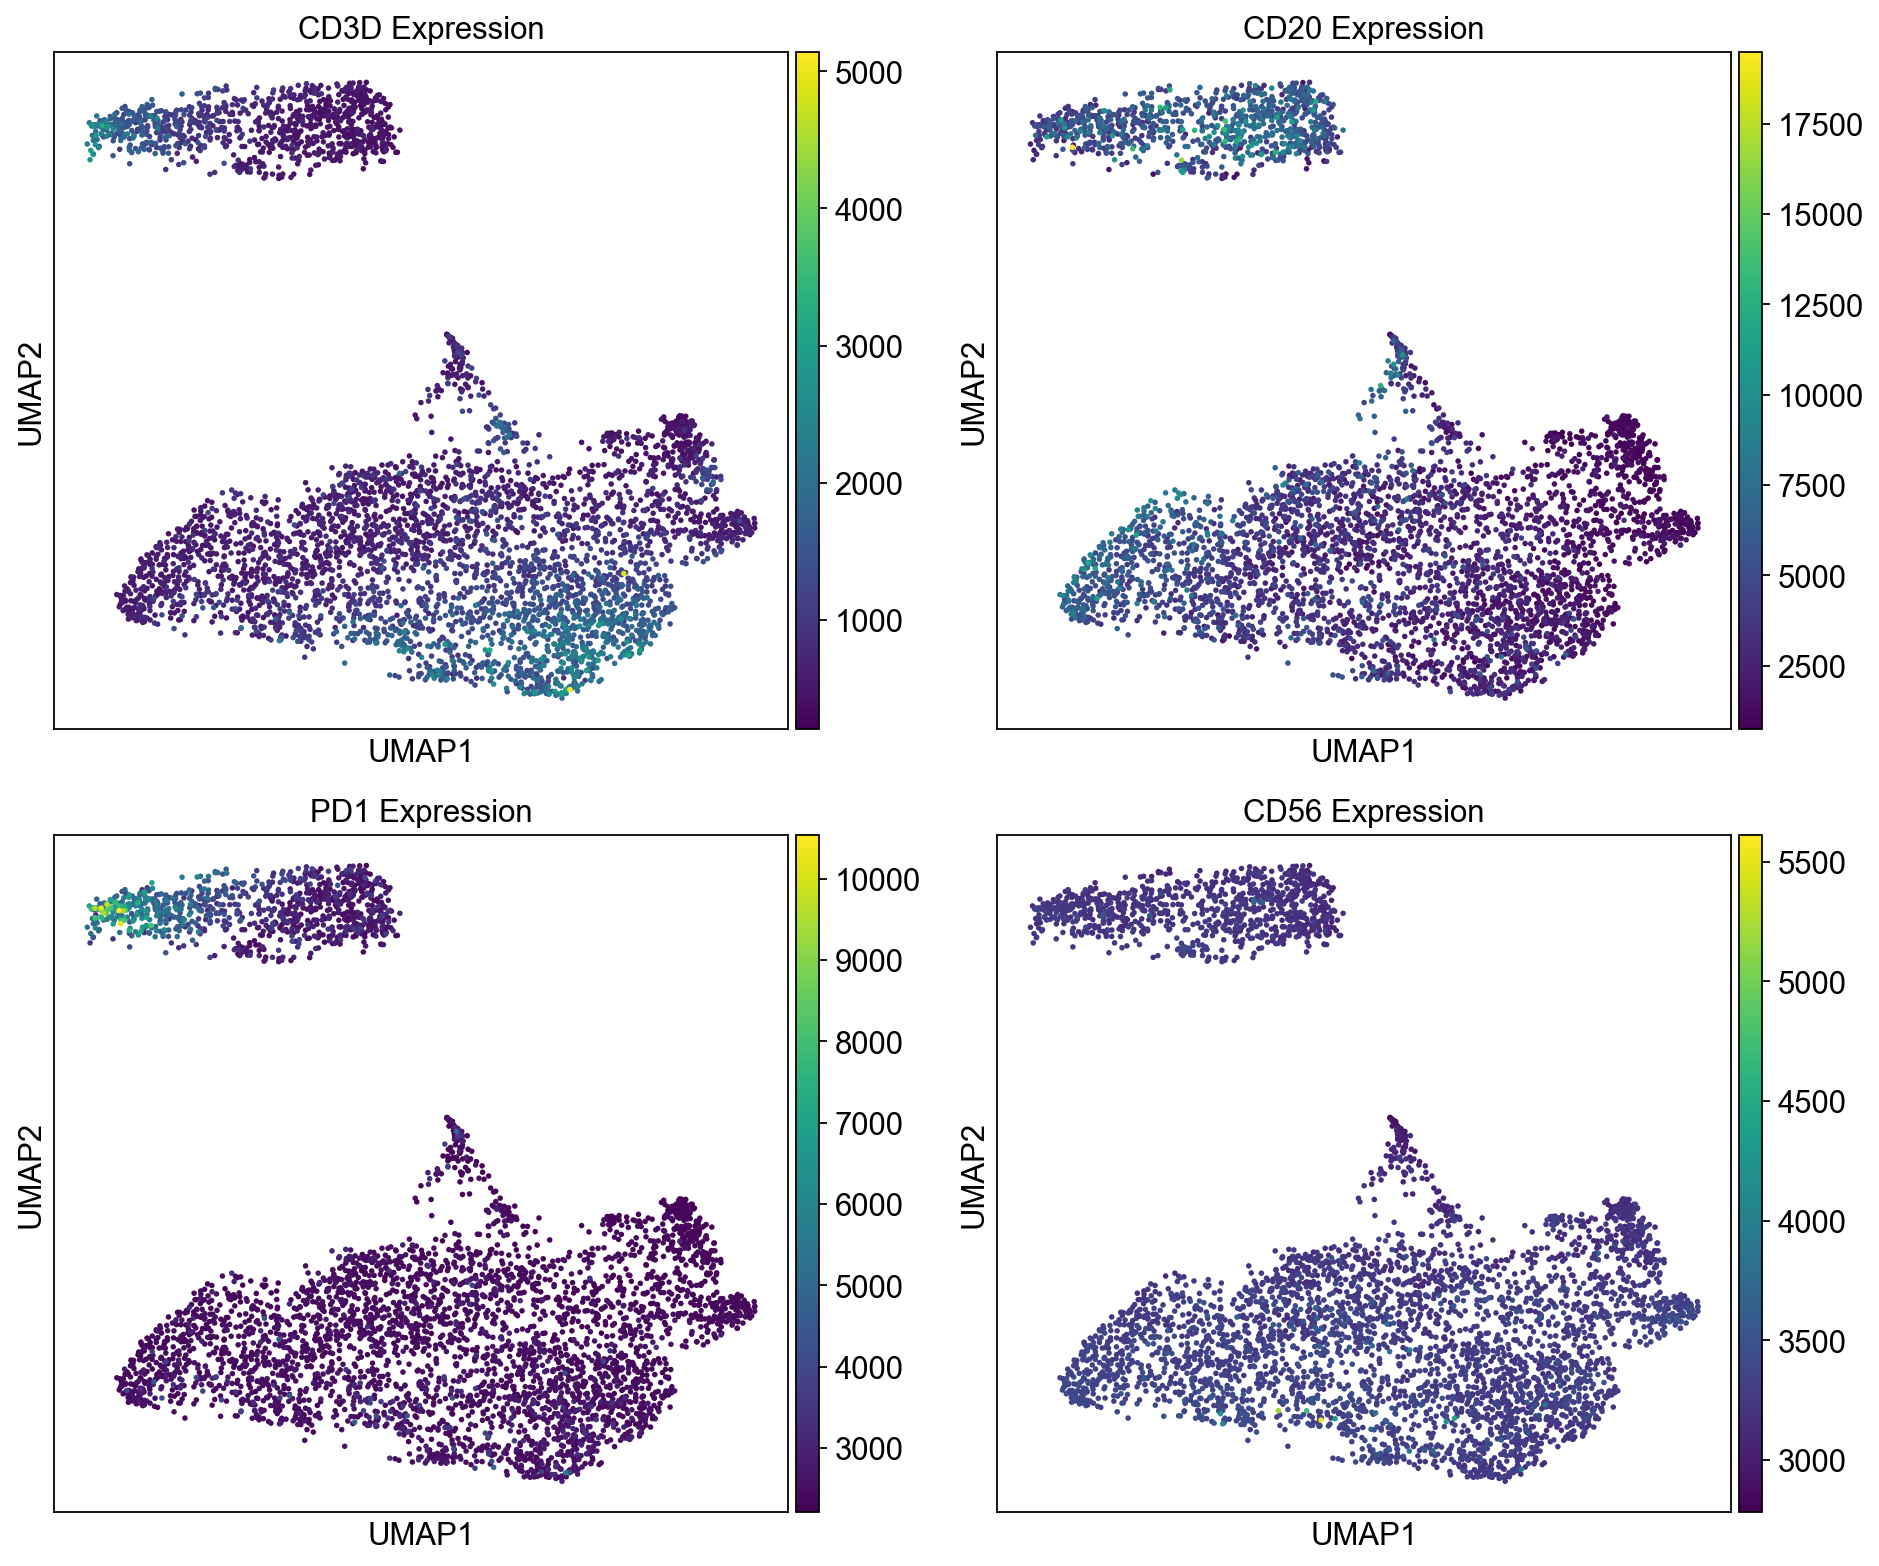

⚠️ Note on CD3D/CD20 boundary:
- Blurred boundaries between CD3D+ and CD20+ cells observed
- May indicate segmentation issues or genuine cell-cell interactions
- Requires validation with original images


In [17]:
# Plot key markers on UMAP
markers_to_plot = ['CD3D', 'CD20', 'PD1', 'CD56']
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, marker in enumerate(markers_to_plot):
    sc.pl.umap(adata, color=marker, ax=axes[i], show=False, 
               color_map='viridis', title=f'{marker} Expression')

plt.tight_layout()
plt.show()

print("⚠️ Note on CD3D/CD20 boundary:")
print("- Blurred boundaries between CD3D+ and CD20+ cells observed")
print("- May indicate segmentation issues or genuine cell-cell interactions")
print("- Requires validation with original images")

## Step 6: Hierarchical Clustering Analysis

### 6.1 Heatmap of Marker Expression by Cell Type

Generates a hierarchical clustering heatmap with dendrograms, where features are assumed to be columns and annotations are rows, grouping cells by annotation and calculating average expression intensities for each feature.

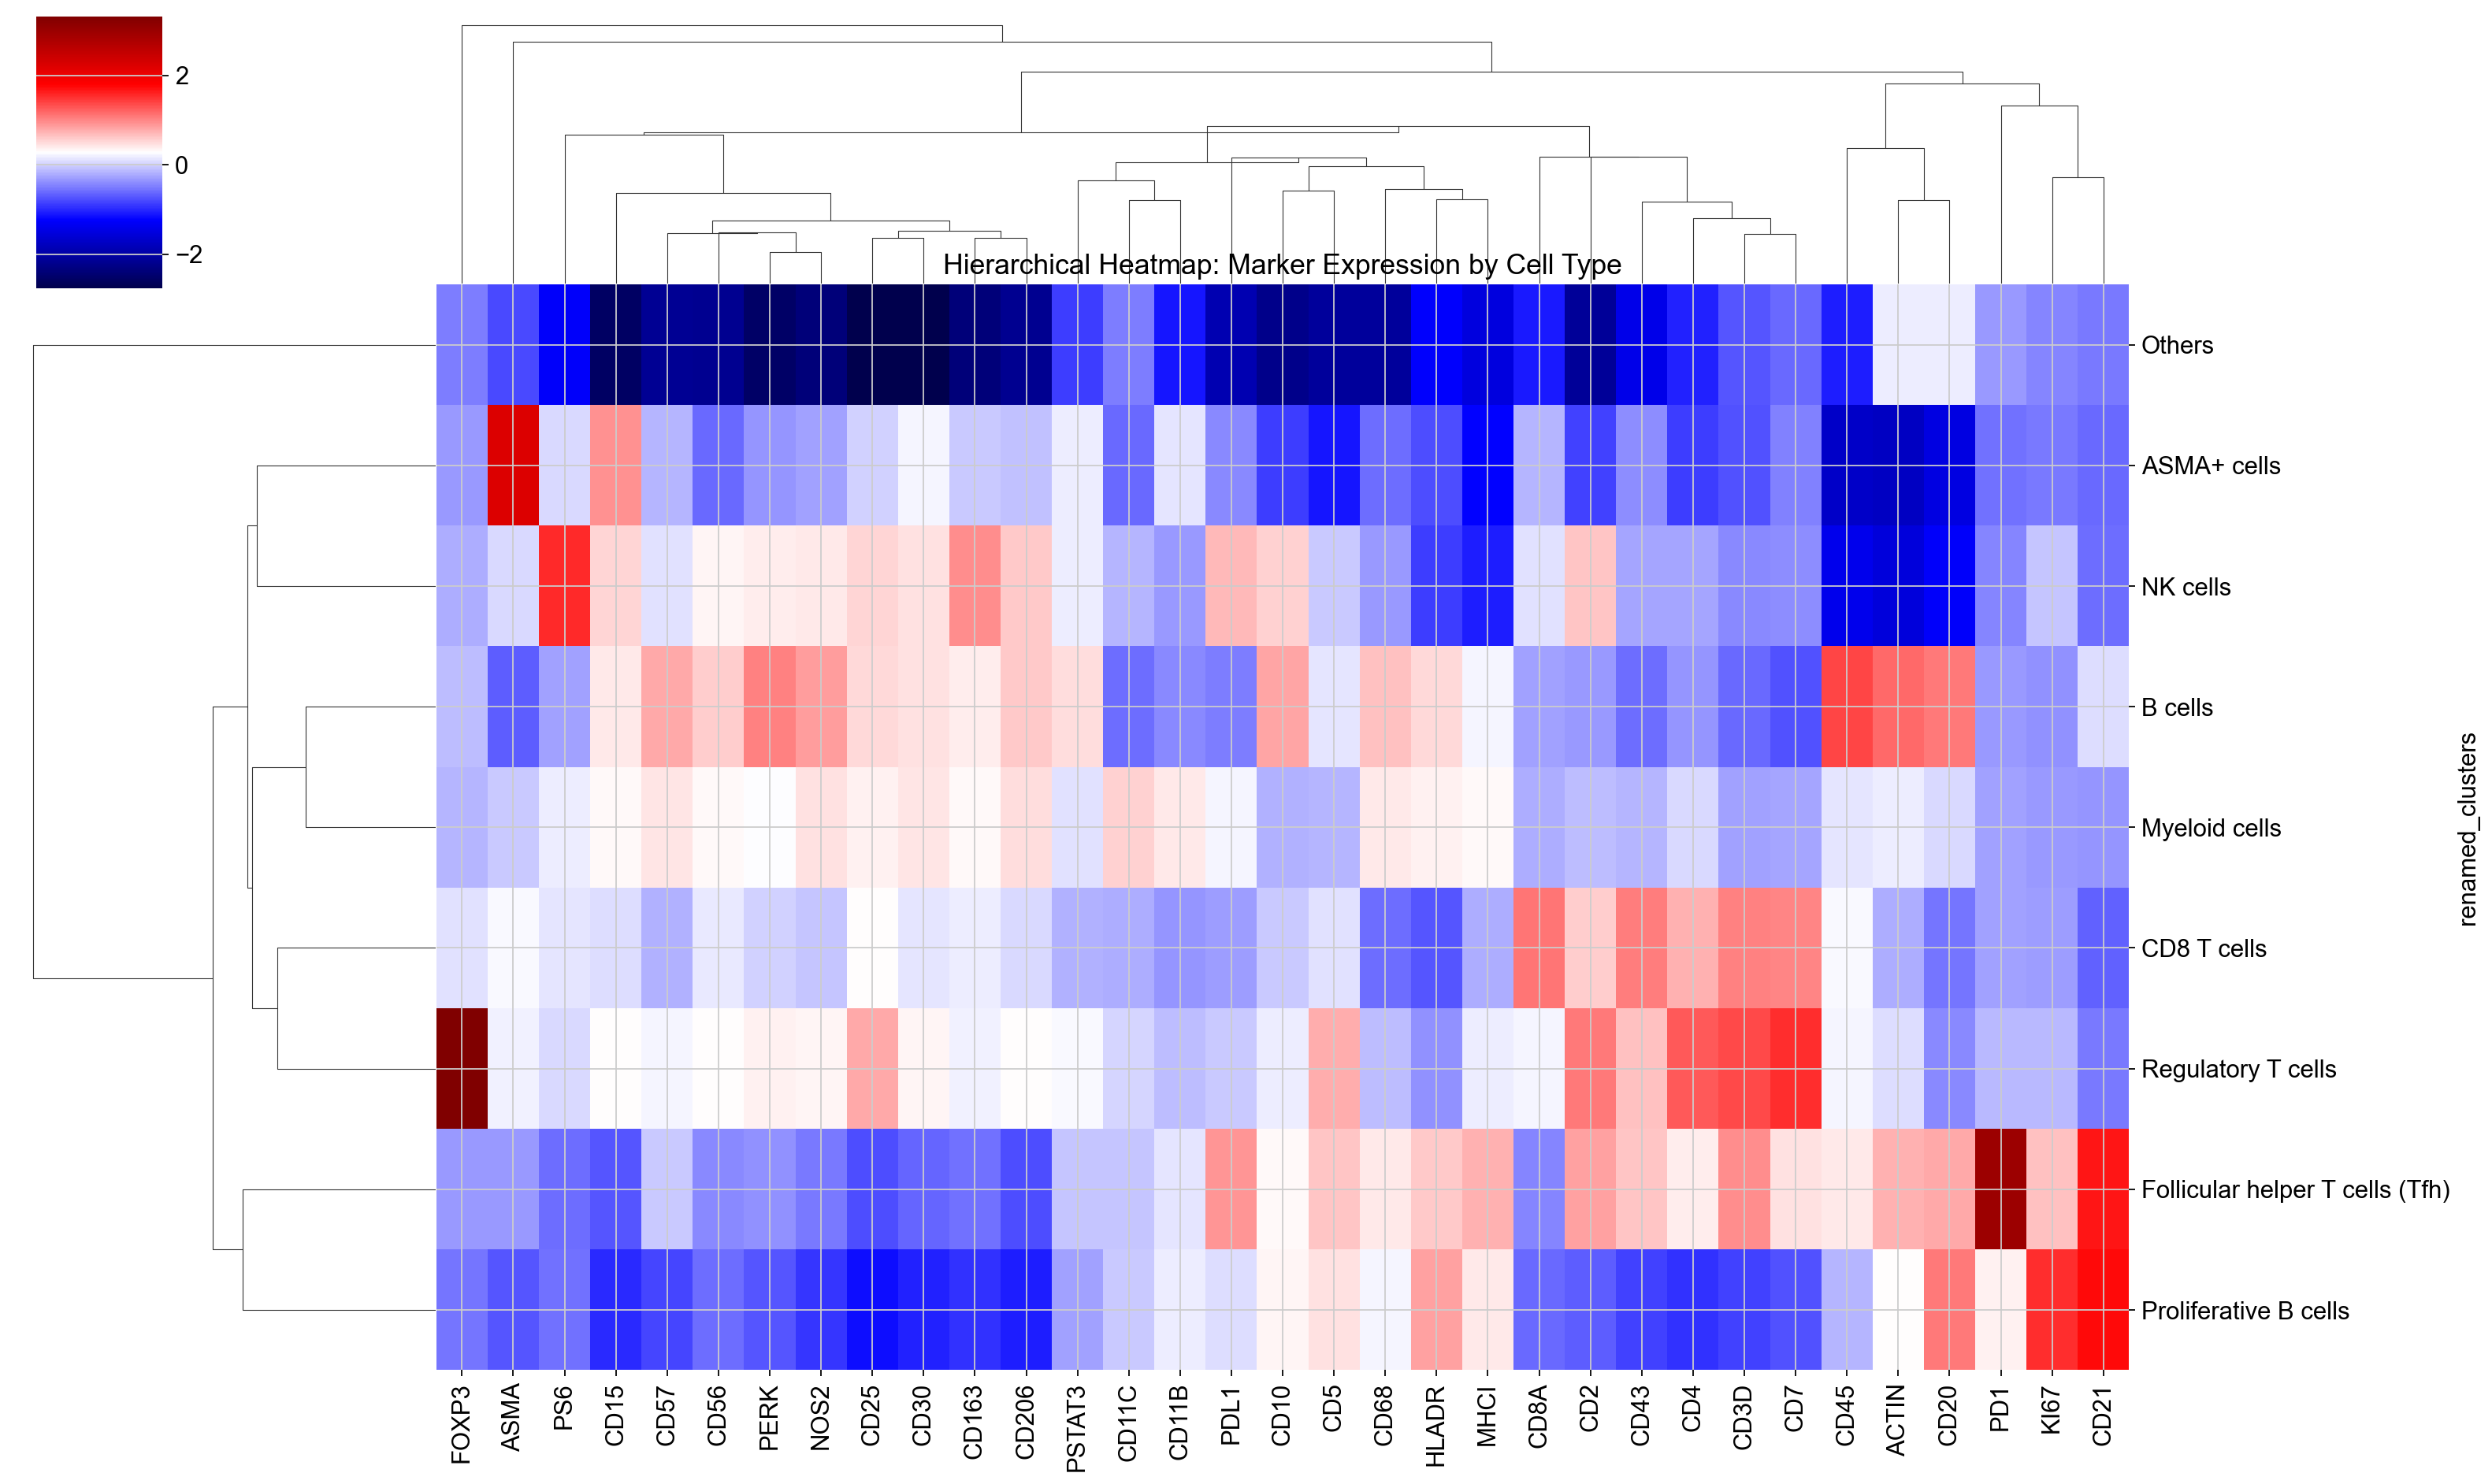

In [18]:
# Create hierarchical heatmap
_, clustergrid, _ = hierarchical_heatmap(
    adata,
    annotation=renamed_column,
    features=None,
    layer=norm_zscore_output_layer,
    cluster_feature=True,
    cluster_annotations=True,
    standard_scale=None,
    z_score=None,
    swap_axes=False,
    rotate_label=False,
    figsize=(20, 12),
    dendrogram_ratio=(0.2, 0.2),
    cmap='seismic'
)

clustergrid.ax_heatmap.set_title('Hierarchical Heatmap: Marker Expression by Cell Type', 
                                fontsize=16)
plt.show()

### 6.2 Sankey Diagram

Visualize the relationship between original clusters and annotated cell types. 

SPAC's Sankey Plot function visualizes annotation relationships within datasets, offering both static and interactive plots. It represents the flow and connection between labels that exist in two sets of annotations, helping users understand how different labels relate to one another. This tool is useful for visualizing complex relationships in biological data, such as the progression of cell states or the connection between different cell types.

Similarly, SPAC's Relational Heatmap function visualizes the relationships between the labels that exist in two annotations. It provides a detailed heatmap that shows how categories from source and target annotations are related, helping users understand complex interactions, such as cellular phenotypes distribution over treatments, region of interests, and clustering results.





Available annotations in adata.obs:
['broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_r1', 'renamed_clusters']


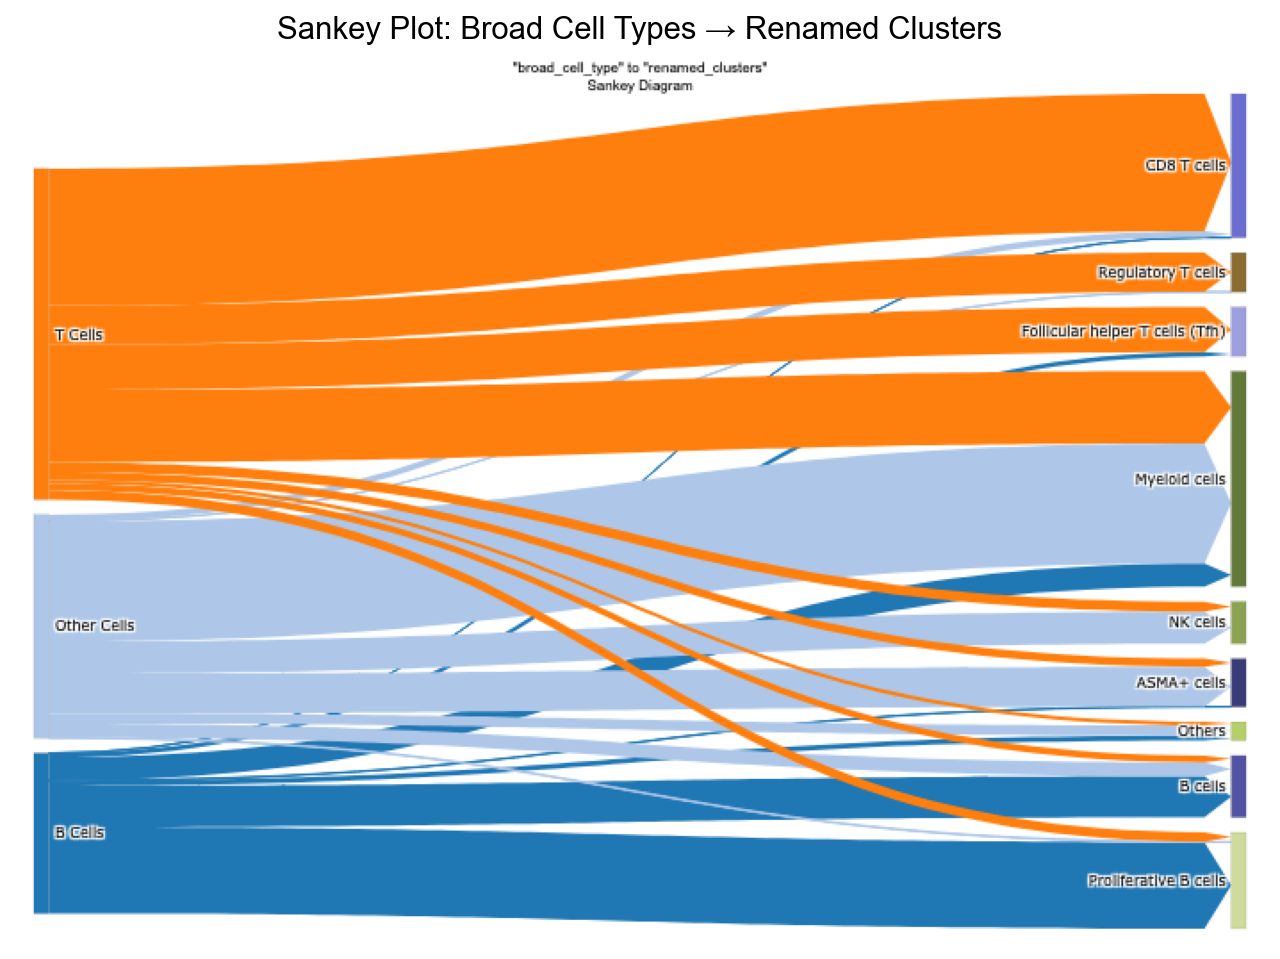

In [19]:
print("Available annotations in adata.obs:")
print(adata.obs.columns.tolist())

# Generate Sankey plot
fig = sankey_plot(
    adata=adata,
    source_annotation='broad_cell_type',
    target_annotation='renamed_clusters',
    source_color_map='tab20',
    target_color_map='tab20b',
    sankey_font=8,
    prefix=False
)

# If you call display(fig) here, the interactive figure may open in a new window.
# !pip install --upgrade nbformat
# display(fig)

# OR Use matplotlib display: convert to static image and display with matplotlib
# Convert to image bytes
img_bytes = fig.to_image(format="png")

# Display with matplotlib
img = PILImage.open(BytesIO(img_bytes))
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Sankey Plot: Broad Cell Types → Renamed Clusters')
plt.show()

## Step 7: Spatial Plot Analysis

SPAC provides two methods: 1. static spatial visualizations of single-cell data, providing a snapshot of cellular features or annotations across a sample; 2. interactive, real-time visual explorations of single-cell spatial data for in-depth analysis.

Specifically, Spatial Plot uses spatial coordinates to plot the chosen feature or annotation across the spatial layout of a single slide. The selection of feature or annotation to color the cells, which could be related to cellular characteristics or experimental conditions, is mutual excusively. Specific examples are shown below.

Interactive Spatial Plot creates dynamic, interactive visualizations by leveraging Plotly Express to generate scatter plots that vividly represent cellular distributions and annotations in a tissue sample. 

### 7.1 Spatial Distribution of Cell Types

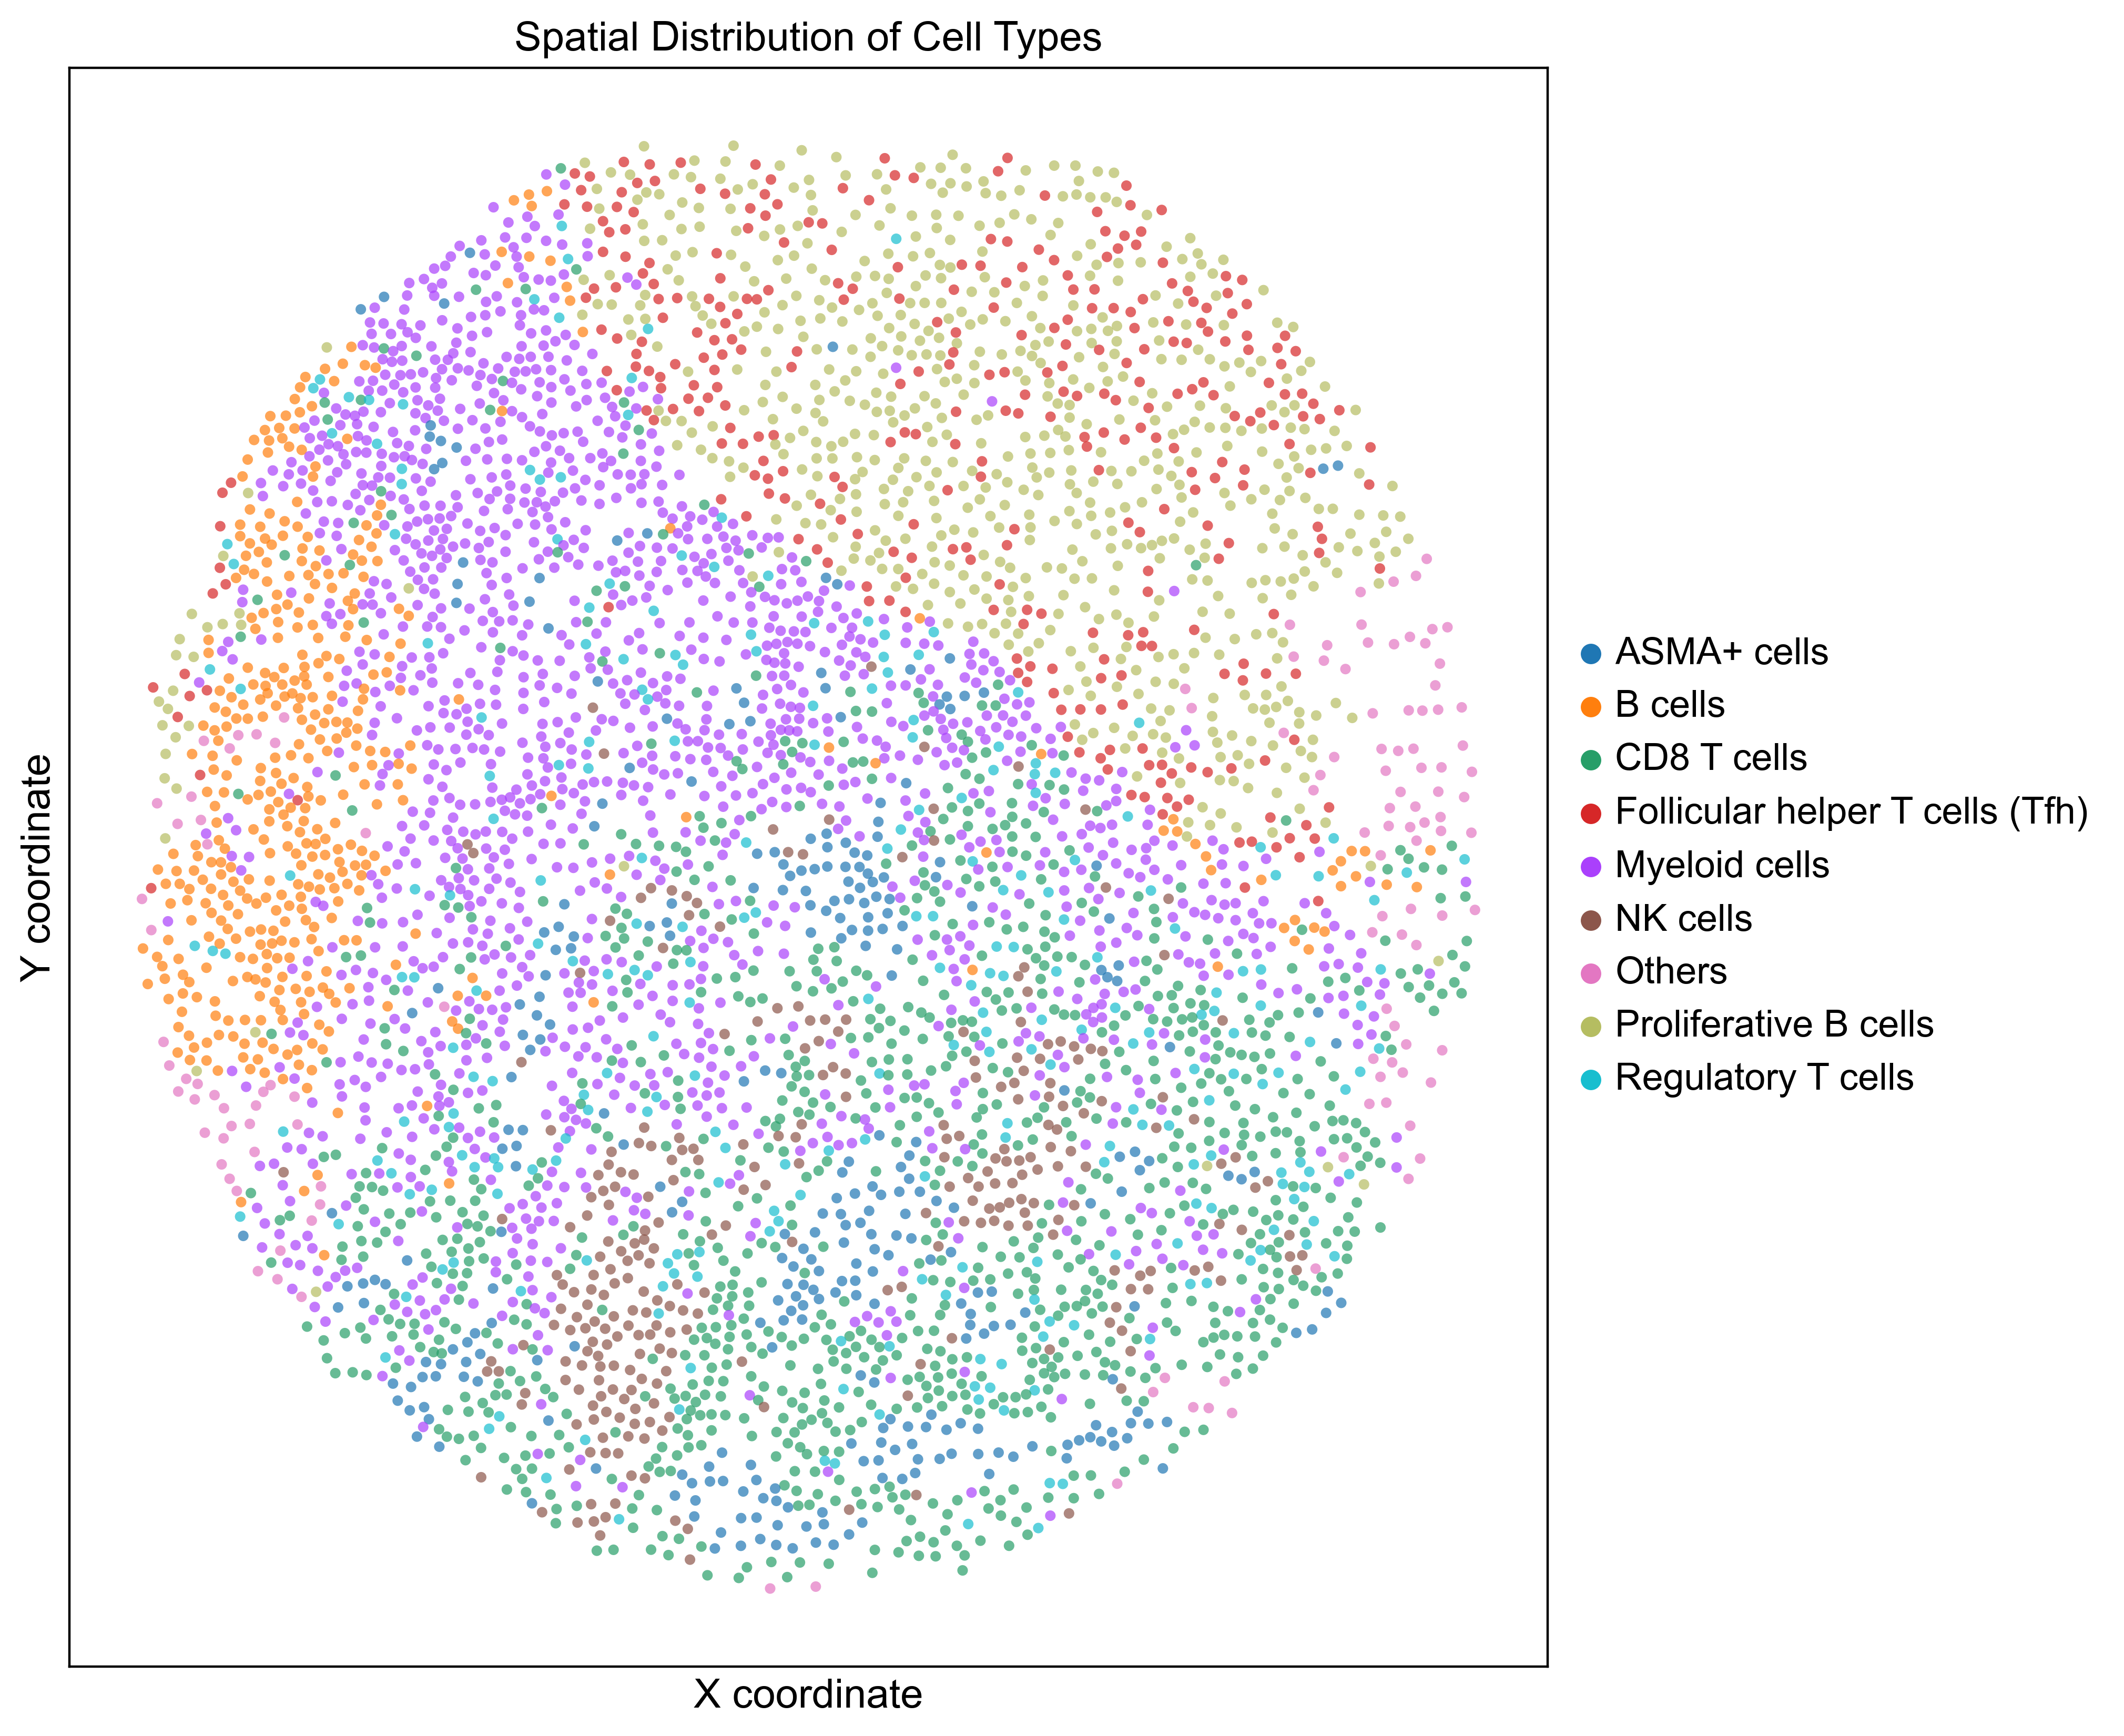

In [20]:
# Create spatial plot
annotation = "renamed_clusters"
plt.rcParams['font.size'] = 12

fig, ax = plt.subplots(figsize=(12, 10), dpi=200)

spatial_plot(
    adata=adata,
    annotation=annotation,
    spot_size=8,
    alpha=0.7,
    ax=ax
)

ax.set_title(f'Spatial Distribution of Cell Types', fontsize=14)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
plt.show()

### 7.2 Spatial Expression of Key Markers

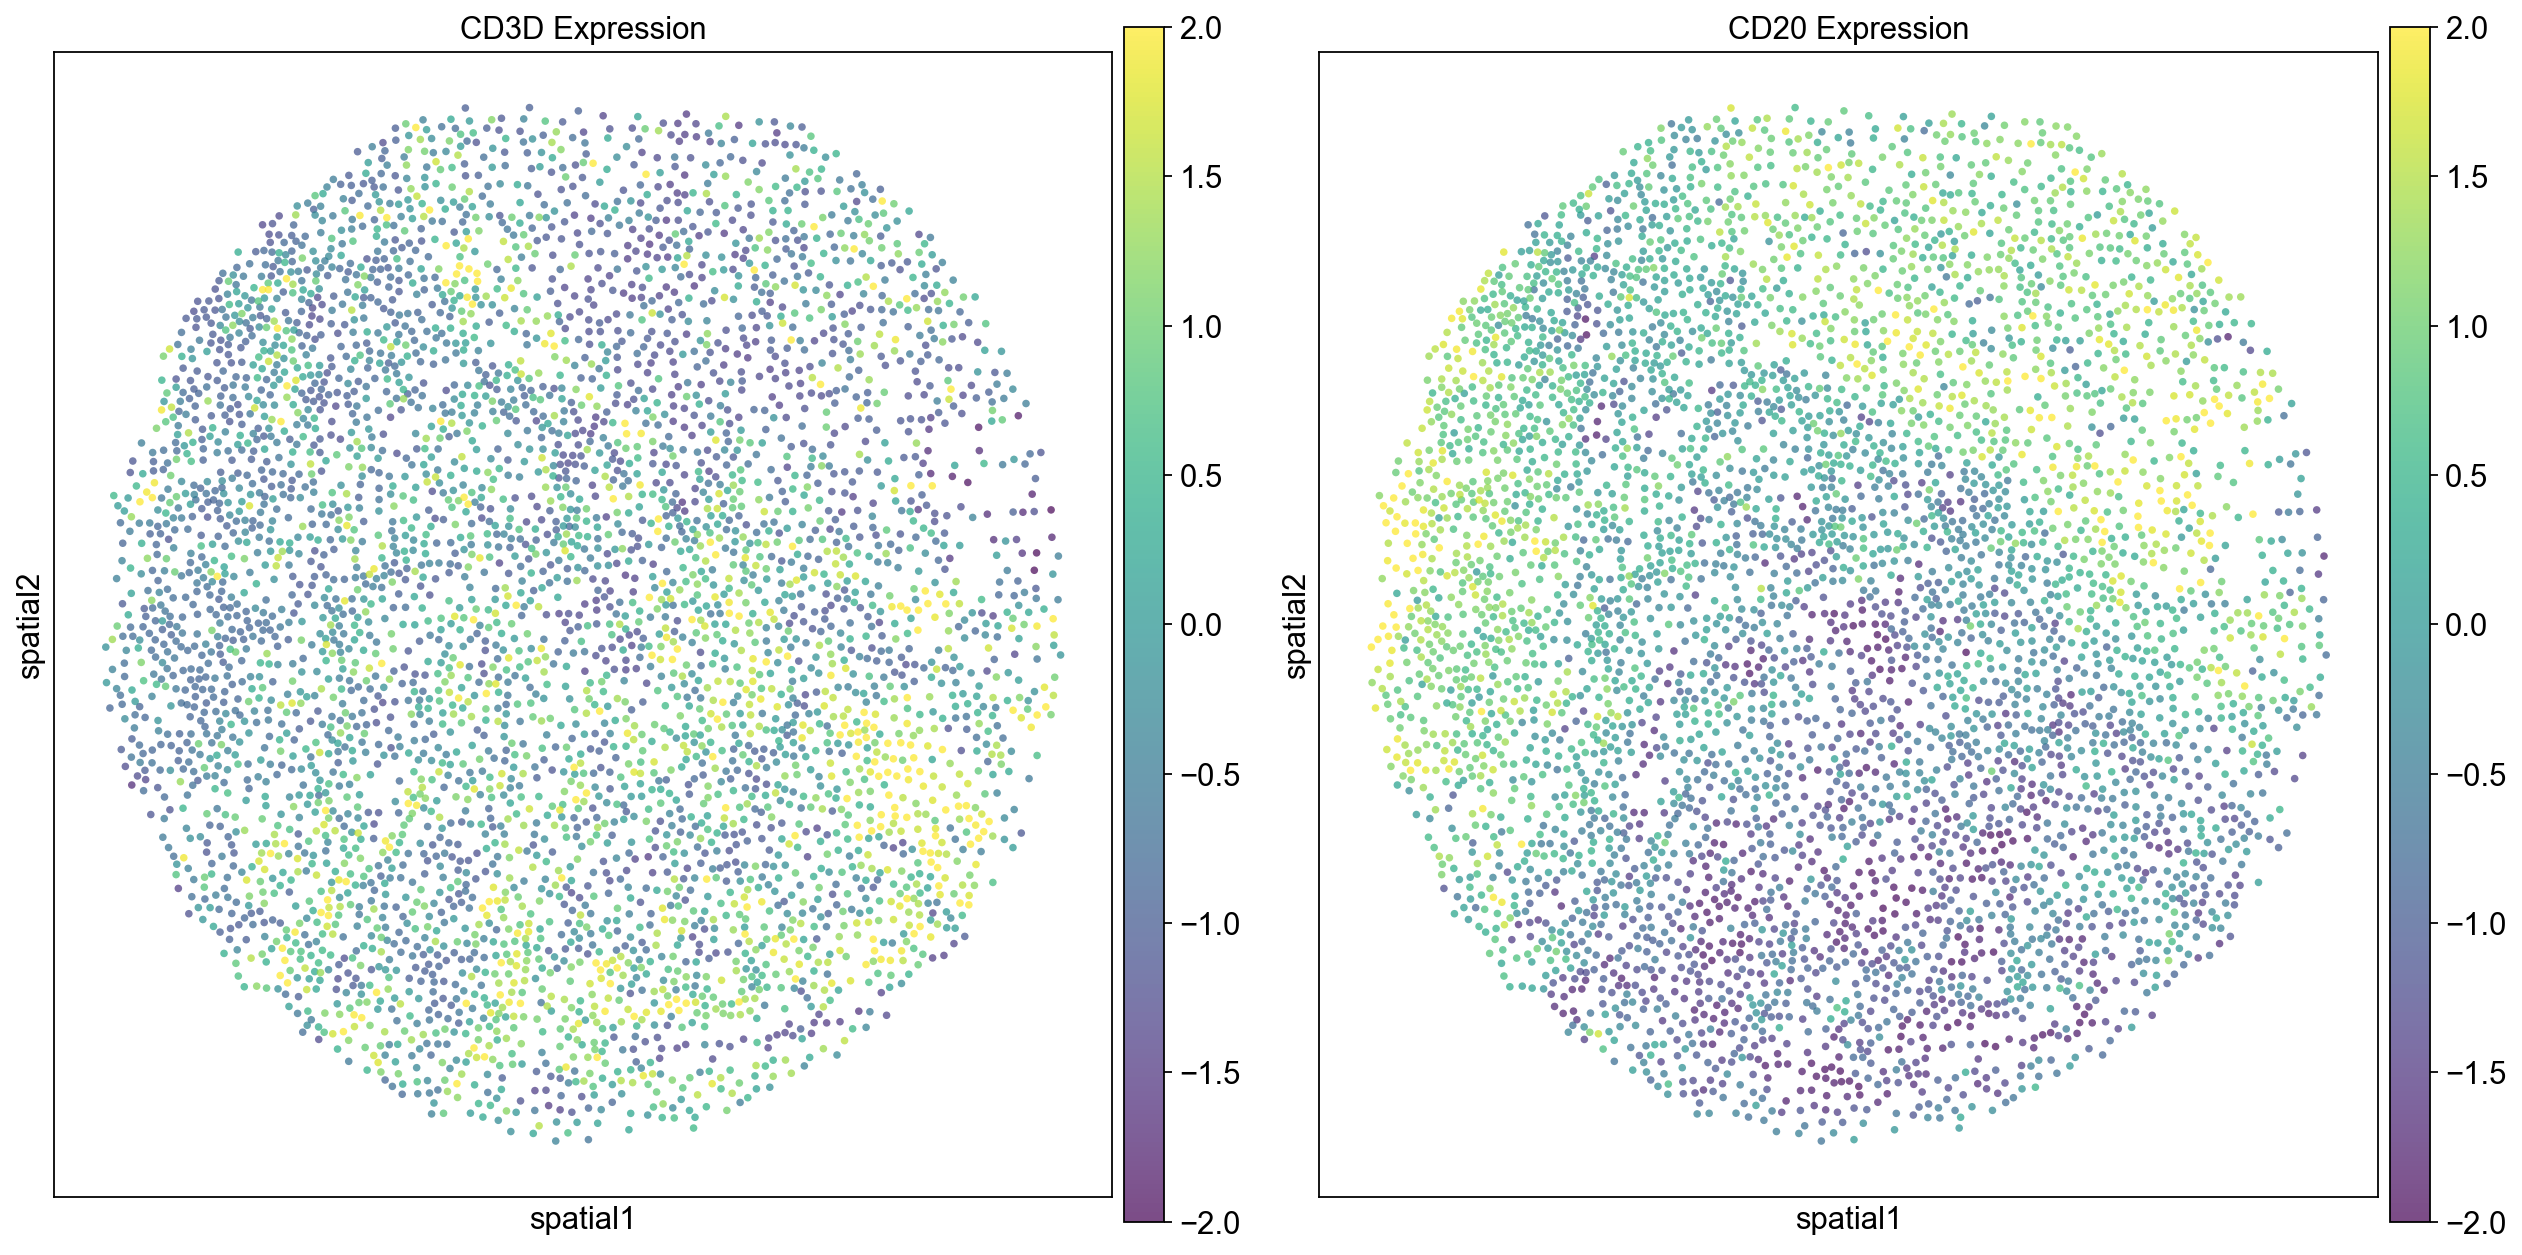

In [21]:
# Plot CD3D and CD20 spatial distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# CD3D distribution
spatial_plot(
    adata=adata,
    feature='CD3D',
    layer=norm_zscore_output_layer,
    spot_size=8,
    alpha=0.7,
    ax=axes[0],
    vmin=-2,
    vmax=2
)
axes[0].set_title('CD3D Expression')

# CD20 distribution
spatial_plot(
    adata=adata,
    feature='CD20',
    layer=norm_zscore_output_layer,
    spot_size=8,
    alpha=0.7,
    ax=axes[1],
    vmin=-2,
    vmax=2
)
axes[1].set_title('CD20 Expression')

plt.tight_layout()
plt.show()

## Step 8: Neighborhood Analysis

### 8.1 Calculate Nearest Neighbors

Calculates the nearest neighbor distances all cells with the label as source (e.g., anchor) phenotype all other cells types via scimap.tl.spatial_distance. This method provides a distance summary that indicates, for each cell, how far it is from the closest cell of every phenotype. The result can reveal whether particular neighbor phenotypes tend to infiltrate in the vicinity of the source phenotype.


In [22]:
# Calculate nearest neighbor distances
calculate_nearest_neighbor(
    adata=adata,
    annotation="renamed_clusters",
    spatial_associated_table="spatial",
    imageid=None,
    label="spatial_distance"
)

print("Nearest neighbor distances calculated and stored in adata.obsm['spatial_distance']")

Running SCIMAP  2.1.3
Preparing data for spatial distance calculation...
Processing Image: dummy_image
Spatial distances stored in adata.obsm['spatial_distance']
Preview of the distance DataFrame:
    Proliferative B cells  Follicular helper T cells (Tfh)  CD8 T cells  \
0              23.951263                        14.393124    65.106849   
1              13.418854                        21.946570   131.822437   
2              20.247170                        32.127516   182.841401   
3              13.340312                        34.250638   296.744091   
4              15.548248                        24.043808   208.718897   

   Myeloid cells     B cells  Regulatory T cells  ASMA+ cells      Others  \
0      66.463845   80.954973           86.664061   154.489135  511.031742   
1     128.137355  145.389003          141.920128   169.805128  534.839987   
2     161.278346  195.348749           98.025538   150.610770  500.551750   
3     166.806641  308.352498           76.612886 

### 8.2 Visualize Nearest Neighbor Distances

Analyze the spatial proximity between Tfh cells and other cell types.

The Nearest Neighbor Visualization function utilizes precomputed nearest neighbor distances between every source phenotype and the closest neighbor phenotype from an upstream calculation step. It displays these nearest neighbor distances (for all cells of source phenotype) in a variety of plot formats (e.g., box, violin, histogram, or KDE). 



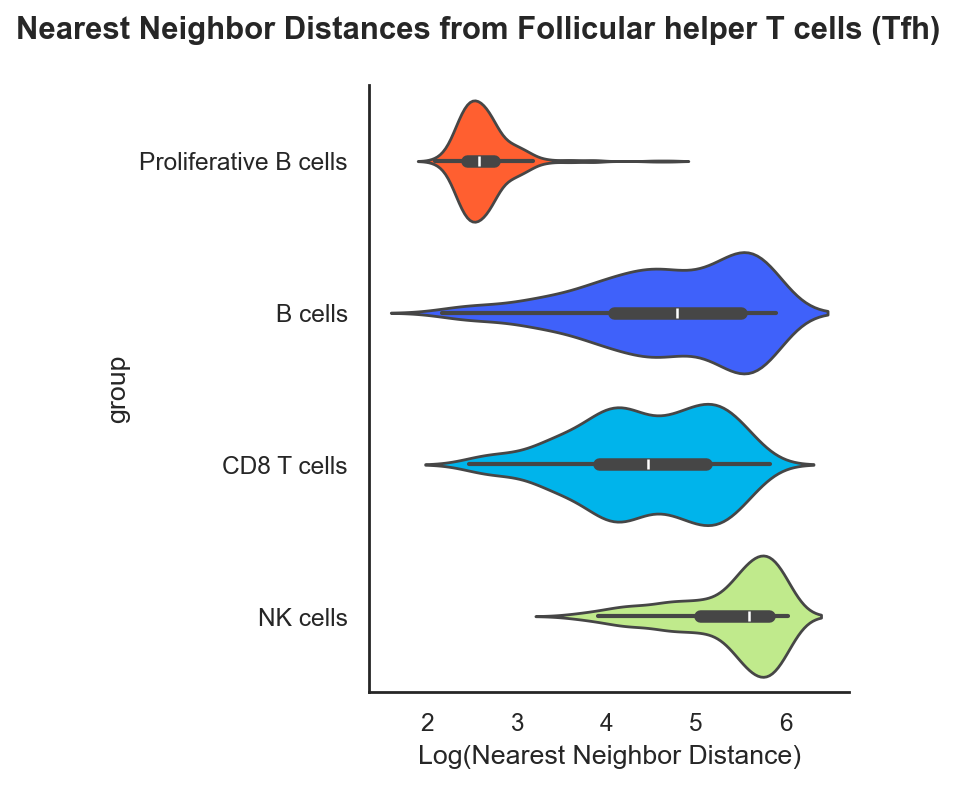

Key finding: Tfh cells are closest to Proliferative B cells,
supporting their role in germinal center function.


In [23]:
# Visualize nearest neighbor distances from Tfh cells
source_label = "Follicular helper T cells (Tfh)"
target_labels = ["Proliferative B cells", "B cells", "CD8 T cells", "NK cells"]

result_dict = visualize_nearest_neighbor(
    adata=adata,
    annotation="renamed_clusters",
    spatial_distance="spatial_distance",
    distance_from=source_label,
    distance_to=target_labels,
    method="numeric",
    plot_type="violin",
    log=True,
    hue="group",
    palette="Set2"
)

plt.suptitle(f'Nearest Neighbor Distances from {source_label}', 
             fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

print("Key finding: Tfh cells are closest to Proliferative B cells,")
print("supporting their role in germinal center function.")

### 8.3 Neighborhood Enrichment Analysis

Spatial Interaction functions employ Squidpy, a python library, to compute spatial statistics for cell-types and clusters, creating a neighborhood graph based on their their spatial coordinates. This tool facilitates the discovery of patterns and relationships in data by examining its spatial characteristics. 

SPAC provide two methods:
1. Cluster Interaction Matrix Analysis: to quantify the number of interactions (e.g., edges) between different cell types.
Interaction Matrix: Given an annotation that defines various cell types (e.g., labels) in the analysis, every element of this square matrix represents the counts the all edges (e.g., interactions) between two cell types: a center cell type, and a neighbor cell type.

2. Neighborhood Enrichment Analysis: to determine if two cell types are neighbors more often than expected by chance. "Expected by chance" refers to the frequency with which two annotations would be neighbors if there were no specific  pattern or preference on how the cells get their labels. In other words, if the cell label of the two annotations were random. An example is shown below:





100%|██████████| 1000/1000 [00:07<00:00, 138.35/s]


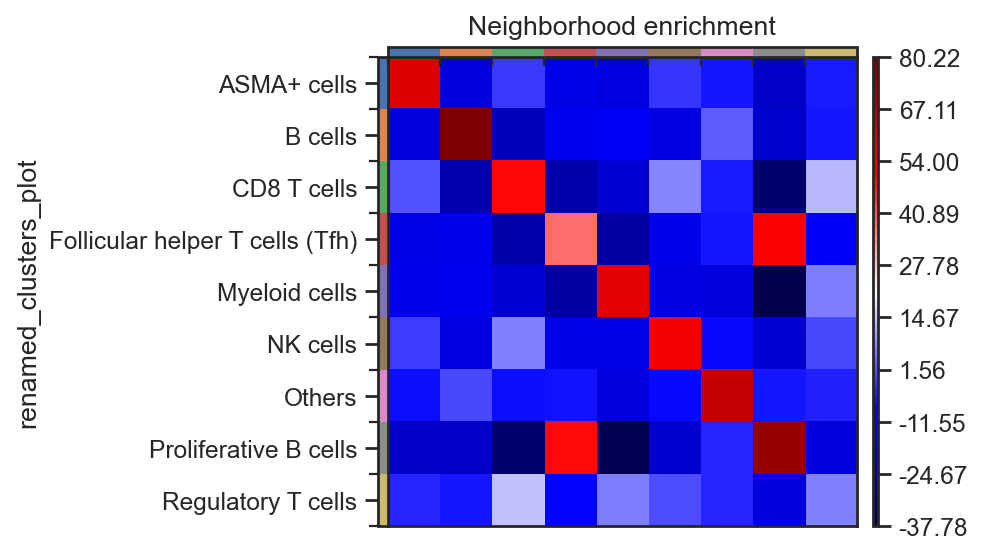

Key findings:
- Tfh cells and Proliferative B cells show high co-localization
- This supports the germinal center microenvironment hypothesis


In [24]:
# Perform neighborhood enrichment analysis
spatial_interaction(
    adata=adata,
    annotation="renamed_clusters",
    analysis_method="Neighborhood Enrichment",
    return_matrix=True,
    n_rings=1,
    n_neighs=6,
    cmap='seismic',
    figsize=(12, 10),
    dpi=200
)

# plt.suptitle('Neighborhood Enrichment Analysis', fontsize=16)
plt.show()

print("Key findings:")
print("- Tfh cells and Proliferative B cells show high co-localization")
print("- This supports the germinal center microenvironment hypothesis")

## Step 9: Ripley's L Analysis

### 9.1 Calculate Ripley's L Statistic

Calculates the Ripley L statistic that measures the amount of clustering/dispersion between two cell phenotypes at different radii.

Specifically, Ripley's L statistic is a method to analyze spatial patterns of cells, determining if two cell types are clustered, randomly distributed, or evenly spaced at different distances. It calculates the L value for various radii by counting the number of neighboring cells of one type (the neighbor phenotype) within a maximum radius R of another type (the center phenotype) and normalizing this count by the overall density of cells in the region. This analysis employs edge correction by excluding cells located near the region's borders within the analytical radius to mitigate edge-effect biases. The method assumes the area analyzed is uniform and that there are enough cells (e.g., at least 30) of both phenotypes to ensure reliable results. 

Ripley’s L can be calculated for regions from different treatment types or compared against a baseline hypothesis of complete spatial randomness (CSR), where cells are randomly distributed within the region based on a Poisson point process. For a valid CSR comparison, the region must be homogeneous and free from barriers like blood vessels that restrict cell movement.

The CSR baseline is created by simulating multiple random distributions of cells. These simulations generate a 95% confidence interval, representing the range of values expected under random conditions. By comparing the observed L statistic to this confidence interval, the analysis identifies distances where the observed cell distribution significantly deviates from randomness, revealing aggregation or dispersion patterns.

This function calculates the Ripley L for two phenotypes at different Radii. Please refer Plot Ripley L function visulizing these results.


### 9.2 Plot Ripley's L Results

visualizes the Ripley L statistic for analyzing spatial interactions between two specified cell phenotypes

EDGE CORRECTION BENCHMARKING FOR RIPLEY'S L ANALYSIS
Demonstrating the impact of edge correction on spatial statistics
--------------------------------------------------------------------------------

Preparing separate AnnData objects for independent analysis...
✓ Created independent copies

A.1 Ripley's L WITH Edge Correction (Guard-Zone Method)
--------------------------------------------------
Processing region:"all".
Cells in region:"4825"


<Figure size 800x480 with 0 Axes>

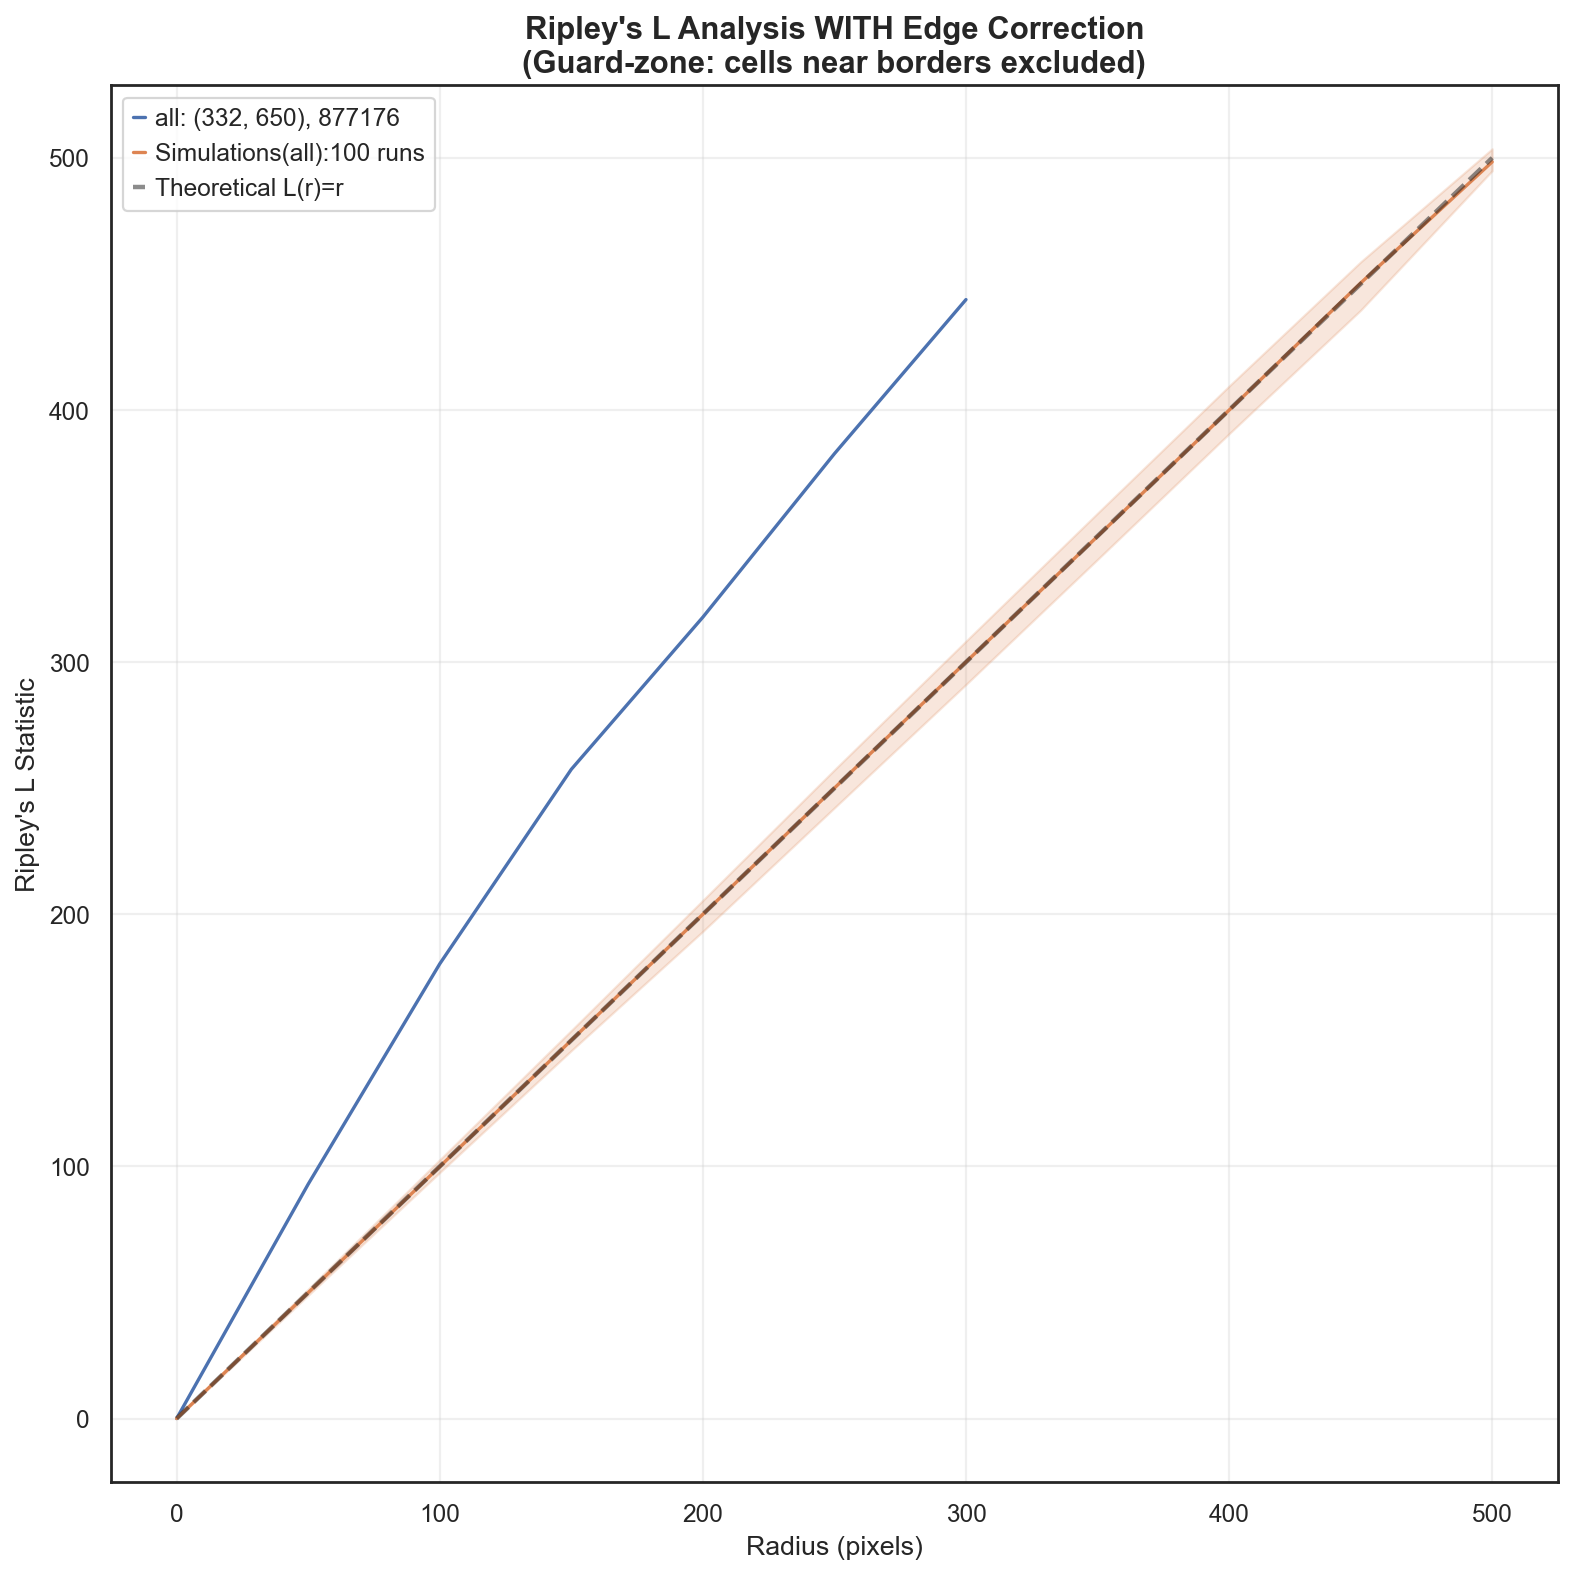

✓ WITH edge correction complete
  Note: CSR envelope aligns with L(r)=r line (45° diagonal)
  Note: Empirical curve may stop earlier when no eligible centers remain

A.2 Ripley's L WITHOUT Edge Correction
--------------------------------------------------
Processing region:"all".
Cells in region:"4825"


<Figure size 800x480 with 0 Axes>

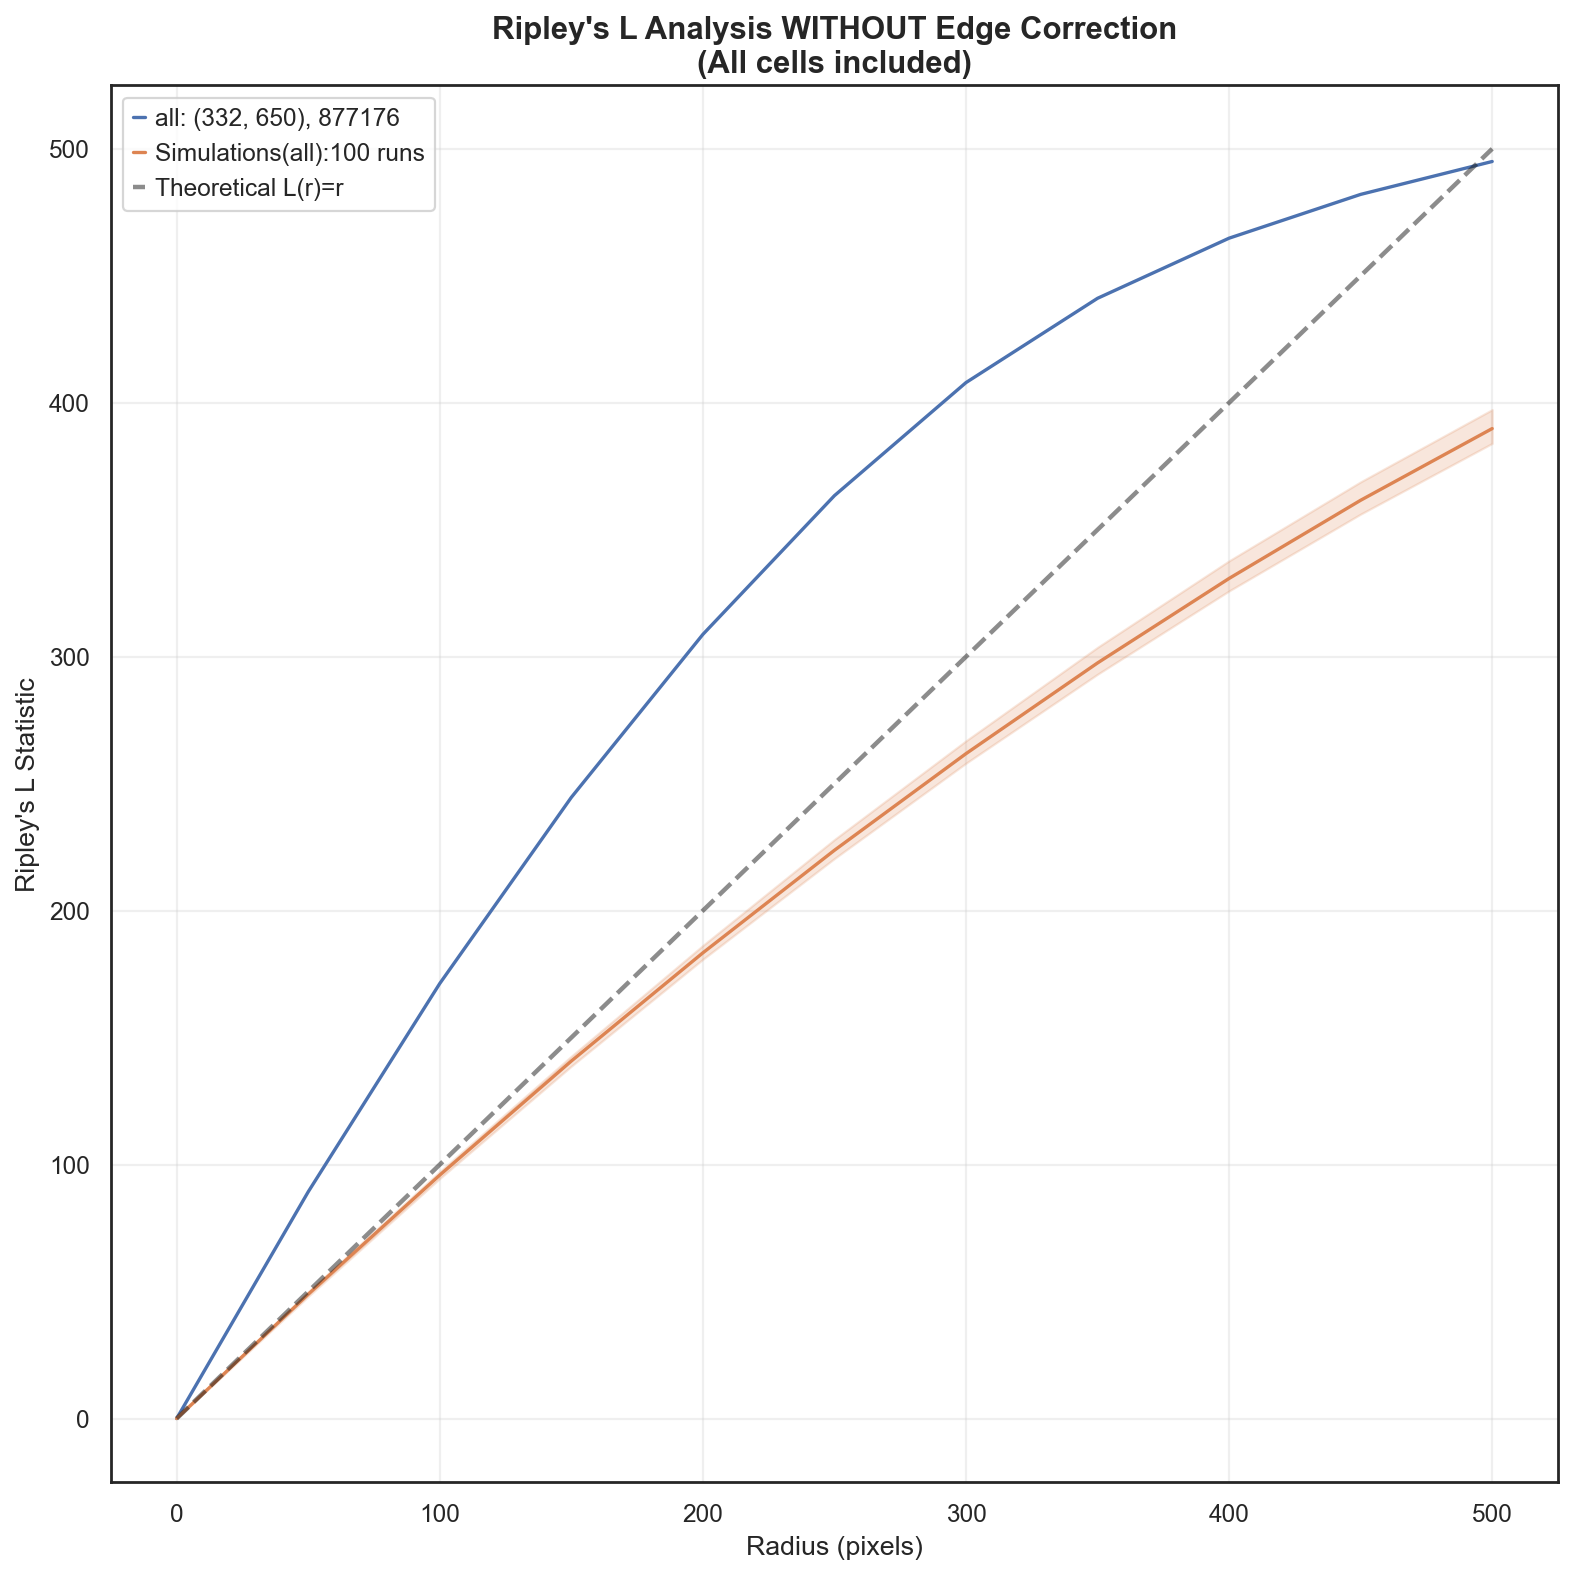

✓ WITHOUT edge correction complete
  Note: CSR envelope bends below L(r)=r at large radii (boundary undercount)

KEY OBSERVATIONS FROM EDGE CORRECTION BENCHMARK

CRITICAL DIFFERENCES IN CSR ENVELOPES:

1. WITH EDGE CORRECTION (Guard-Zone Method):
   • CSR envelope (orange) aligns with theoretical L(r)=r line (~45° diagonal)
   • This is the expected behavior under complete spatial randomness
   • Centers within distance r of boundaries are excluded from analysis
   • Empirical curve may truncate earlier when insufficient interior centers remain
   • Provides unbiased null hypothesis for statistical inference

2. WITHOUT EDGE CORRECTION:
   • CSR envelope deviates below L(r)=r at larger radii
   • Boundary undercount causes downward bias in the null distribution
   • This artificially inflates the apparent clustering signal
   • All cells included regardless of proximity to boundaries
   • May lead to false positive detection of clustering

3. BIOLOGICAL INTERPRETATION:
   • Both method

In [25]:
"""
Edge Correction Benchmarking for Ripley's L Analysis
================================================================================
This section addresses the reviewer's comment about benchmarking SPAC's edge 
correction implementation compared to methods without edge correction.
================================================================================
"""

import copy
import matplotlib.pyplot as plt

print("=" * 80)
print("EDGE CORRECTION BENCHMARKING FOR RIPLEY'S L ANALYSIS")
print("=" * 80)
print("Demonstrating the impact of edge correction on spatial statistics")
print("-" * 80 + "\n")

# Define extended radii for comprehensive analysis
radii = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# ============================================================================
# Clone AnnData objects for separate analysis
# ============================================================================
print("Preparing separate AnnData objects for independent analysis...")
adata_with_edge = copy.deepcopy(adata)
adata_without_edge = copy.deepcopy(adata)
print("✓ Created independent copies\n")

# ============================================================================
# A.1 Calculate and Plot Ripley's L WITH Edge Correction
# ============================================================================
print("A.1 Ripley's L WITH Edge Correction (Guard-Zone Method)")
print("-" * 50)

# Calculate WITH edge correction on first copy
ripley_l(
    adata_with_edge,
    annotation="renamed_clusters",
    phenotypes=["Follicular helper T cells (Tfh)", "Proliferative B cells"],
    distances=radii,
    n_simulations=100,
    seed=42,
    spatial_key="spatial",
    edge_correction=True
)

# Create fresh figure for WITH edge correction
plt.figure(figsize=(10, 6))
fig_with, df_with = plot_ripley_l(
    adata_with_edge,
    phenotypes=("Follicular helper T cells (Tfh)", "Proliferative B cells"),
    sims=True,
    return_df=True
)

# Add theoretical L(r)=r line
plt.plot([0, max(radii)], [0, max(radii)], 'k--', alpha=0.5, linewidth=2, label='Theoretical L(r)=r')
plt.title("Ripley's L Analysis WITH Edge Correction\n(Guard-zone: cells near borders excluded)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Radius (pixels)", fontsize=12)
plt.ylabel("Ripley's L Statistic", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ WITH edge correction complete")
print("  Note: CSR envelope aligns with L(r)=r line (45° diagonal)")
print("  Note: Empirical curve may stop earlier when no eligible centers remain\n")

# ============================================================================
# A.2 Calculate and Plot Ripley's L WITHOUT Edge Correction
# ============================================================================
print("A.2 Ripley's L WITHOUT Edge Correction")
print("-" * 50)

# Calculate WITHOUT edge correction on second copy
ripley_l(
    adata_without_edge,
    annotation="renamed_clusters",
    phenotypes=["Follicular helper T cells (Tfh)", "Proliferative B cells"],
    distances=radii,
    n_simulations=100,
    seed=42,
    spatial_key="spatial",
    edge_correction=False
)

# Create fresh figure for WITHOUT edge correction
plt.figure(figsize=(10, 6))
fig_without, df_without = plot_ripley_l(
    adata_without_edge,
    phenotypes=("Follicular helper T cells (Tfh)", "Proliferative B cells"),
    sims=True,
    return_df=True
)

# Add theoretical L(r)=r line
plt.plot([0, max(radii)], [0, max(radii)], 'k--', alpha=0.5, linewidth=2, label='Theoretical L(r)=r')
plt.title("Ripley's L Analysis WITHOUT Edge Correction\n(All cells included)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Radius (pixels)", fontsize=12)
plt.ylabel("Ripley's L Statistic", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ WITHOUT edge correction complete")
print("  Note: CSR envelope bends below L(r)=r at large radii (boundary undercount)\n")

# ============================================================================
# A.3 Key Observations and Interpretation
# ============================================================================
print("=" * 80)
print("KEY OBSERVATIONS FROM EDGE CORRECTION BENCHMARK")
print("=" * 80)

print("""
CRITICAL DIFFERENCES IN CSR ENVELOPES:

1. WITH EDGE CORRECTION (Guard-Zone Method):
   • CSR envelope (orange) aligns with theoretical L(r)=r line (~45° diagonal)
   • This is the expected behavior under complete spatial randomness
   • Centers within distance r of boundaries are excluded from analysis
   • Empirical curve may truncate earlier when insufficient interior centers remain
   • Provides unbiased null hypothesis for statistical inference

2. WITHOUT EDGE CORRECTION:
   • CSR envelope deviates below L(r)=r at larger radii
   • Boundary undercount causes downward bias in the null distribution
   • This artificially inflates the apparent clustering signal
   • All cells included regardless of proximity to boundaries
   • May lead to false positive detection of clustering

3. BIOLOGICAL INTERPRETATION:
   • Both methods show L(r) > simulation envelope (significant clustering)
   • Tfh-Proliferative B cell association is genuine, not an edge artifact
   • Edge correction provides more conservative, statistically robust estimates
   • The clustering signal persists after proper boundary handling

4. WHY THE CORRECTED CURVE STOPS EARLIER:
   With guard-zone edge correction, centers within distance r of the boundary 
   are excluded. As r increases, fewer centers qualify for analysis. Eventually,
   no eligible centers remain, causing the series to terminate. This is expected
   behavior and ensures statistical validity.

5. VALIDATION OF SPAC'S IMPLEMENTATION:
   This benchmark demonstrates that SPAC's edge correction:
   ✓ Produces properly calibrated CSR null distributions
   ✓ Mitigates boundary-induced biases  
   ✓ Provides more reliable statistical inference
   ✓ Distinguishes genuine biological patterns from edge artifacts

RECOMMENDATION: Always use edge_correction=True for rigorous spatial analysis,
especially when analyzing patterns at large radii or in small tissue sections.
""")

# Store results back to original adata with edge correction as default
adata.uns['ripley_l_with_edge'] = adata_with_edge.uns['ripley_l'].copy()
adata.uns['ripley_l_without_edge'] = adata_without_edge.uns['ripley_l'].copy()
adata.uns['ripley_l'] = adata_with_edge.uns['ripley_l'].copy()

print("\n✓ Benchmarking complete. Edge-corrected results set as default.")
print("✓ Both analyses stored in adata.uns for reference:")
print("  - adata.uns['ripley_l_with_edge']")
print("  - adata.uns['ripley_l_without_edge']")
print("=" * 80)

## Step 10: Summary and Conclusions

### Key Quality Control Findings:
1. **CD56 Expression**: Unexpectedly high, suggesting potential background noise
   - Requires validation with original staining images
2. **CD3D/CD20 Boundary**: Blurred boundaries observed
   - May indicate segmentation artifacts 

### Major Discovery - Cluster 5:
- Identified as **Follicular Helper T (Tfh) cells**
- Unique marker profile: PD1+, CD21+, CD3D+, CD4+, CD57+
- Located in germinal center-like microenvironment
- Shows strong spatial association with Proliferative B cells

### Spatial Organization Insights:
1. **Tfh-B Cell Interactions**: 
   - Confirmed by multiple spatial analyses
   - Neighborhood enrichment shows high co-localization
   - Ripley's L statistics indicate significant clustering
   - Nearest neighbor analysis shows close proximity

2. **Biological Significance**:
   - Tfh cells are crucial for germinal center formation
   - Their proximity to Proliferative B cells supports their role in:
     - B cell maturation
     - Antibody affinity maturation
     - Memory B cell development

### Next Steps:
1. **Technical Validation**:
   - Validate CD56 staining quality in original images
   - Investigate CD3D/CD20 boundary regions for artifacts

2. **Biological Validation**:
   - Add markers: CXCR5 (Tfh cells), CCR7 (dendritic cells)
   - Perform functional assays on identified populations

3. **Extended Analysis**:
   - Investigate other spatial patterns in the tissue
   - Analyze additional tissue samples for reproducibility

### Data Preservation
All analysis results are stored in the `adata` object in memory and can be accessed for further analysis or exported as needed.


In [27]:
# Display final AnnData object information
print("Final AnnData object:")
print(adata)
print(f"\nAvailable layers: {list(adata.layers.keys())}")
print(f"Available annotations: {list(adata.obs.columns)}")
print(f"Spatial coordinates: {adata.obsm.keys()}")


Final AnnData object:
AnnData object with n_obs × n_vars = 4825 × 33
    obs: 'broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_r1', 'renamed_clusters', 'CD3Dspatial_plot', 'CD20spatial_plot'
    uns: 'phenograph_features', 'phenograph_k60_r1_colors', 'renamed_clusters_colors', '_spac_palettes', 'spatial_neighbors', 'renamed_clusters_plot_nhood_enrichment', 'ripley_l_with_edge', 'ripley_l_without_edge', 'ripley_l'
    obsm: 'spatial', 'X_umap', 'spatial_distance'
    layers: 'arcsinh_percentile', 'arcsinh_z_scores'
    obsp: 'spatial_connectivities', 'spatial_distances'

Available layers: ['arcsinh_percentile', 'arcsinh_z_scores']
Available annotations: ['broad_cell_type', 'detailed_cell_type', 'manual_phenotype', 'phenograph_k60_r1', 'renamed_clusters', 'CD3Dspatial_plot', 'CD20spatial_plot']
Spatial coordinates: KeysView(AxisArrays with keys: spatial, X_umap, spatial_distance)


**Note**: This analysis was performed using SPAC v0.9.0. For questions or support, contact NCISPAC@nih.gov.